In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [17]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: 맑은 고딕으로 설정 (Windows 환경 시)
plt.rcParams['axes.unicode_minus'] = False

In [8]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2012년~2023년/건강조사_2012~2022_통합.csv") # 당뇨 치료

고혈압인데 고혈압 관리 안 한 사람 특징 확인

In [16]:
# 고혈압 전단계 또는 고혈압이면서 치료 안 한 사람만 남김
data = data[(data['HE_HP'].isin([3, 4])) & (data['DI1_pt'] == 0)]

In [ ]:
# 고혈압 전단계 또는 고혈압이면서 치료 안 한 사람만 남김
#data = data[(data['HE_DM_HbA1c'].isin([2, 3])) & (data['DE1_3'] == 2)]

In [10]:
data.info

<bound method DataFrame.info of                 mod_d             id       ID_fam    year  region  town_t  \
117     b'2022.03.08'  b'A110963502'  b'A1109635'  2012.0     1.0     1.0   
124     b'2022.03.08'  b'A110967702'  b'A1109677'  2012.0     1.0     1.0   
239     b'2022.03.08'  b'A112980901'  b'A1129809'  2012.0     1.0     1.0   
358     b'2022.03.08'  b'A115980303'  b'A1159803'  2012.0     1.0     1.0   
406     b'2022.03.08'  b'A117966901'  b'A1179669'  2012.0     1.0     1.0   
...               ...            ...          ...     ...     ...     ...   
83849  b'2024.01.11.'            NaN  b'YP015742'  2022.0    17.0     2.0   
83867  b'2024.01.11.'            NaN  b'YP132325'  2022.0    17.0     1.0   
83965  b'2024.01.11.'            NaN  b'YP384225'  2022.0    17.0     1.0   
84004  b'2024.01.11.'            NaN  b'YR133942'  2022.0     8.0     2.0   
84031  b'2024.01.11.'            NaN  b'YR137036'  2022.0     8.0     2.0   

       apt_t      psu  sex   age  age_month

In [17]:
import pandas as pd

# 남기고 싶은 컬럼 리스트
columns_to_keep = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    # 'L_OUT_FQ', 
    # 'BP1','BD1_11', 'BS3_2', 'BE5_1', 
    'HE_obe', 'HE_HP', 'HE_DM_HbA1c',
    'DE1_dg', 'DI1_dg',
    'DI1_pt'
]

# 원래 데이터프레임이 df일 때
data = data[columns_to_keep]


In [18]:
def iqr_clip(series, lower_quantile=0.25, upper_quantile=0.75, clip_range=1.5):
    q1 = series.quantile(lower_quantile)
    q3 = series.quantile(upper_quantile)
    iqr = q3 - q1
    lower_bound = q1 - clip_range * iqr
    upper_bound = q3 + clip_range * iqr
    return series.clip(lower=lower_bound, upper=upper_bound)

# 적용
data['HE_glu'] = iqr_clip(data['HE_glu'])
data['HE_alt'] = iqr_clip(data['HE_alt'])

In [20]:
# HE_DM_HbA1c
if 'HE_DM_HbA1c' in data.columns:
    data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DE1_dg' in data.columns:
        print(f"DE1_dg missing ratio: {data['DE1_dg'].isnull().mean()}")
        data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].fillna(data['DE1_dg'].map({0: 1, 1: 3}))
    # 남은 결측치는 드랍랍
    if data['HE_DM_HbA1c'].isnull().any():
        data = data[data['HE_DM_HbA1c'].notnull()]
    print(f"HE_DM_HbA1c NaN count after: {data['HE_DM_HbA1c'].isnull().sum()}")

# HE_obe
if 'HE_obe' in data.columns:
    data['HE_obe'] = data['HE_obe'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'HE_BMI' in data.columns:
        # BMI가 KNN 대체된 경우 표시
        data['HE_BMI_imputed'] = data['HE_BMI'].isnull().astype(int)
        data['HE_obe'] = data.apply(
            lambda row: row['HE_obe'] if pd.notna(row['HE_obe']) else (
                1 if row['HE_BMI'] < 18.5 else
                2 if row['HE_BMI'] < 25 else
                3 if row['HE_BMI'] < 30 else
                4 if row['HE_BMI'] < 35 else
                5 if row['HE_BMI'] < 40 else
                6
            ),
            axis=1
        )
    # 남은 결측치는 드랍랍
    if data['HE_obe'].isnull().any():
        data = data[data['HE_obe'].notnull()]
    print(f"HE_obe NaN count after: {data['HE_obe'].isnull().sum()}")

# HE_HP
if 'HE_HP' in data.columns:
    data['HE_HP'] = data['HE_HP'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DI1_dg' in data.columns:
        print(f"DI1_dg missing ratio: {data['DI1_dg'].isnull().mean()}")
        data['HE_HP'] = data['HE_HP'].fillna(data['DI1_dg'].map({0: 1, 1: 4}))
    # 남은 결측치는 드랍랍
    if data['HE_HP'].isnull().any():
        data = data[data['HE_HP'].notnull()]
    print(f"HE_HP NaN count after: {data['HE_HP'].isnull().sum()}")


#결측치 비율 낮은 변수 처리
# low_missing_columns = [
#     'DI1_dg', 
#     'DE1_dg', 
# ]
continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data



DE1_dg missing ratio: 0.0
HE_DM_HbA1c NaN count after: 0
HE_obe NaN count after: 0
DI1_dg missing ratio: 0.0
HE_HP NaN count after: 0
Median for HE_wt: 64.6
Median for HE_ht: 164.4
Median for HE_BMI: 24.615231827515593


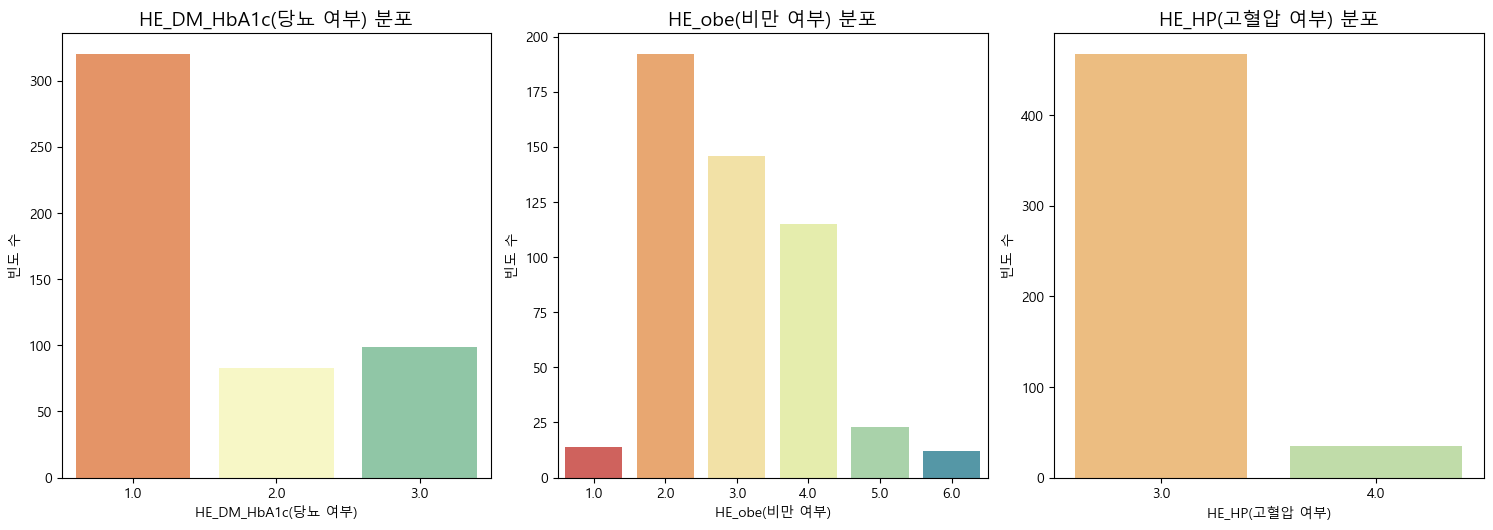

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': 'HE_DM_HbA1c(당뇨 여부)',
    'HE_obe': 'HE_obe(비만 여부)',
    'HE_HP': 'HE_HP(고혈압 여부)'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


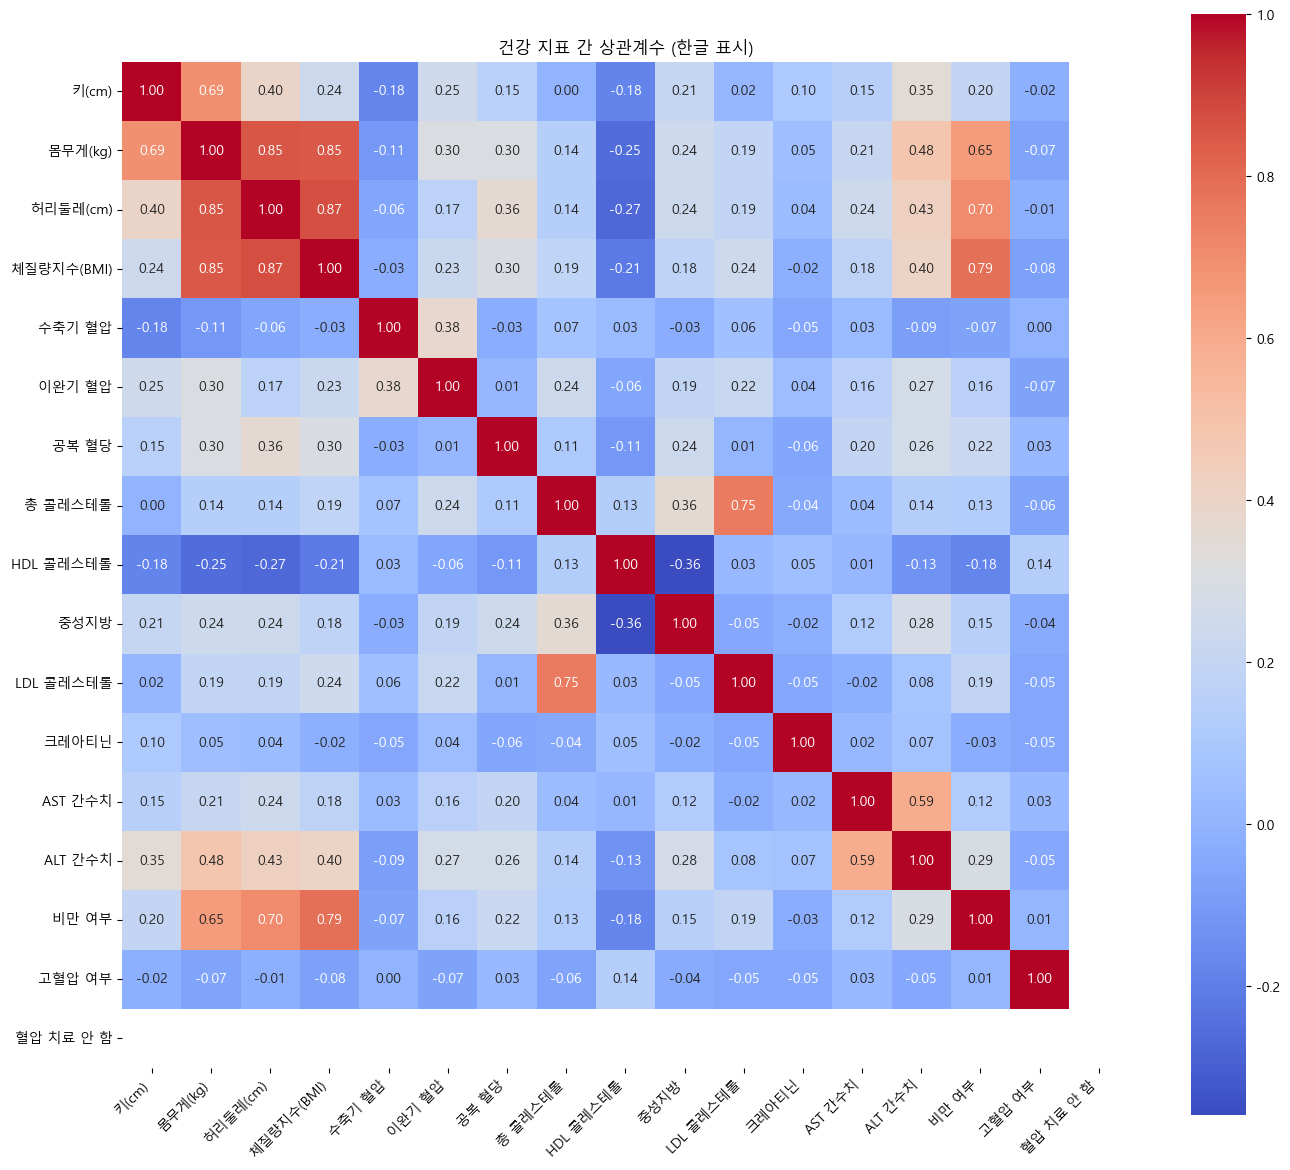

In [23]:
column_name_map = {
    'HE_ht': '키(cm)',
    'HE_wt': '몸무게(kg)',
    'HE_wc': '허리둘레(cm)',
    'HE_BMI': '체질량지수(BMI)',
    'HE_sbp1': '수축기 혈압',
    'HE_dbp1': '이완기 혈압',
    'HE_glu': '공복 혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤',
    'HE_TG': '중성지방',
    'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌',
    'HE_ast': 'AST 간수치',
    'HE_alt': 'ALT 간수치',
    'HE_obe': '비만 여부',
    'HE_HP': '고혈압 여부',
    'DI1_pt' : '혈압 치료 안 함'
}


correlation_columns = [
    'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'DE1_3', 'DI1_pt'
]

import seaborn as sns
import matplotlib.pyplot as plt

# 보고 싶은 변수만 추출
selected_columns = list(column_name_map.keys())
correlation_matrix = data[selected_columns].corr()

# 컬럼명을 한글로 변환
correlation_matrix.columns = [column_name_map[col] for col in correlation_matrix.columns]
correlation_matrix.index = [column_name_map[col] for col in correlation_matrix.index]

# 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("건강 지표 간 상관계수 (한글 표시)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

📊 타겟 변수 상관 분석 - 고혈압


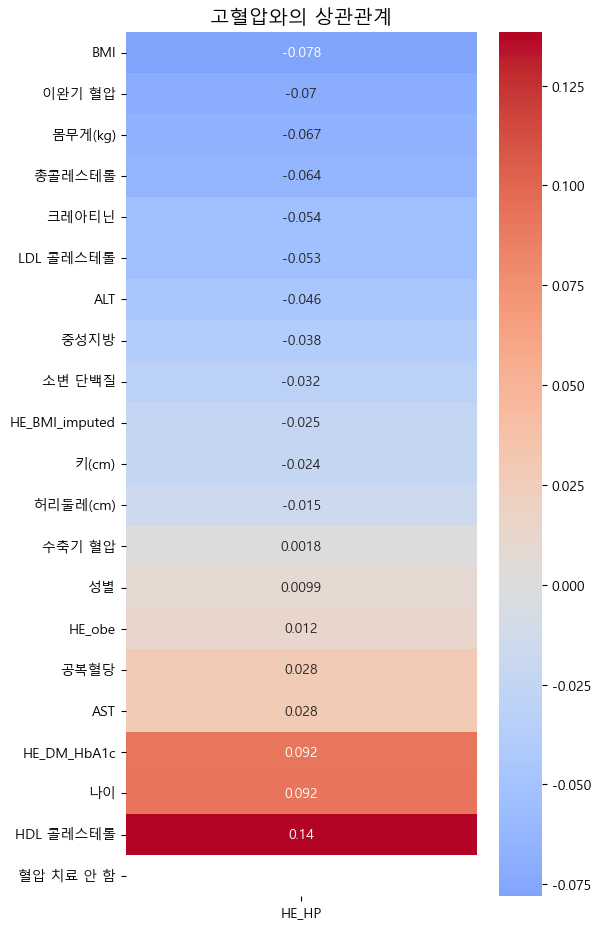

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# 변수 이름 -> 한글 매핑 사전
feature_name_ko = {
    'HE_ht': '키(cm)', 'HE_wt': '몸무게(kg)', 'HE_wc': '허리둘레(cm)', 'HE_BMI': 'BMI',
    'HE_sbp1': '수축기 혈압', 'HE_dbp1': '이완기 혈압',
    'HE_Upro': '소변 단백질', 'HE_glu': '공복혈당', 'HE_chol': '총콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤', 'HE_TG': '중성지방', 'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌', 'HE_ast': 'AST', 'HE_alt': 'ALT',
    'sex': '성별', 'age': '나이',
    'DI1_pt' : '혈압 치료 안 함'
}

# 타겟 이름 -> 한글 매핑
target_name_ko = {

    'HE_HP': '고혈압'
}

# 제외할 컬럼
exclude_cols = ['year', 'ID', 'DE1_dg', 'DI1_dg'] + list(target_name_ko.keys())

# input features 자동 지정
input_features = [col for col in data.columns if col not in exclude_cols]

for target in target_name_ko.keys():
    print(f"📊 타겟 변수 상관 분석 - {target_name_ko[target]}")
    
    # 수치형 변수만 포함한 데이터프레임
    subset = data[input_features + [target]].copy()
    subset = subset.select_dtypes(include='number')

    # 상관계수 계산
    corr_with_target = subset.corr()[[target]].drop(index=target)
    corr_with_target = corr_with_target.sort_values(by=target, ascending=True)

    # 한글 라벨로 인덱스 변환
    corr_with_target.index = [feature_name_ko.get(col, col) for col in corr_with_target.index]

    # 시각화
    plt.figure(figsize=(6, len(corr_with_target) * 0.4 + 1))
    sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', center=0)
    plt.title(f"{target_name_ko[target]}와의 상관관계", fontsize=14)
    plt.tight_layout()
    plt.show()


고혈압인데 치료 안 한 사람을 드랍

In [ ]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2012년~2023년/건강조사_2012~2022_통합.csv")

In [52]:
# 고혈압 전단계 또는 고혈압이면서 치료 안 한 사람만 버림
data = data[~((data['HE_HP'].isin([3, 4])) & (data['DI1_pt'] == 0))]

In [53]:
import pandas as pd

# 남기고 싶은 컬럼 리스트
columns_to_keep = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    # 'L_OUT_FQ', 
    # 'BP1','BD1_11', 'BS3_2', 'BE5_1', 
    'HE_obe', 'HE_HP', 'HE_DM_HbA1c',
    'DE1_dg', 'DI1_dg',
    'DI1_pt'
]

# 원래 데이터프레임이 df일 때
data = data[columns_to_keep]

In [54]:
def iqr_clip(series, lower_quantile=0.25, upper_quantile=0.75, clip_range=1.5):
    q1 = series.quantile(lower_quantile)
    q3 = series.quantile(upper_quantile)
    iqr = q3 - q1
    lower_bound = q1 - clip_range * iqr
    upper_bound = q3 + clip_range * iqr
    return series.clip(lower=lower_bound, upper=upper_bound)

# 적용
data['HE_glu'] = iqr_clip(data['HE_glu'])
data['HE_alt'] = iqr_clip(data['HE_alt'])

# HE_DM_HbA1c
if 'HE_DM_HbA1c' in data.columns:
    data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DE1_dg' in data.columns:
        print(f"DE1_dg missing ratio: {data['DE1_dg'].isnull().mean()}")
        data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].fillna(data['DE1_dg'].map({0: 1, 1: 3}))
    # 남은 결측치는 드랍랍
    if data['HE_DM_HbA1c'].isnull().any():
        data = data[data['HE_DM_HbA1c'].notnull()]
    print(f"HE_DM_HbA1c NaN count after: {data['HE_DM_HbA1c'].isnull().sum()}")

# HE_obe
if 'HE_obe' in data.columns:
    data['HE_obe'] = data['HE_obe'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'HE_BMI' in data.columns:
        # BMI가 KNN 대체된 경우 표시
        data['HE_BMI_imputed'] = data['HE_BMI'].isnull().astype(int)
        data['HE_obe'] = data.apply(
            lambda row: row['HE_obe'] if pd.notna(row['HE_obe']) else (
                1 if row['HE_BMI'] < 18.5 else
                2 if row['HE_BMI'] < 25 else
                3 if row['HE_BMI'] < 30 else
                4 if row['HE_BMI'] < 35 else
                5 if row['HE_BMI'] < 40 else
                6
            ),
            axis=1
        )
    # 남은 결측치는 드랍랍
    if data['HE_obe'].isnull().any():
        data = data[data['HE_obe'].notnull()]
    print(f"HE_obe NaN count after: {data['HE_obe'].isnull().sum()}")

# HE_HP
if 'HE_HP' in data.columns:
    data['HE_HP'] = data['HE_HP'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DI1_dg' in data.columns:
        print(f"DI1_dg missing ratio: {data['DI1_dg'].isnull().mean()}")
        data['HE_HP'] = data['HE_HP'].fillna(data['DI1_dg'].map({0: 1, 1: 4}))
    # 남은 결측치는 드랍랍
    if data['HE_HP'].isnull().any():
        data = data[data['HE_HP'].notnull()]
    print(f"HE_HP NaN count after: {data['HE_HP'].isnull().sum()}")


#결측치 비율 낮은 변수 처리
# low_missing_columns = [
#     'DI1_dg', 
#     'DE1_dg', 
# ]
continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data



DE1_dg missing ratio: 0.05705428954423593
HE_DM_HbA1c NaN count after: 0
HE_obe NaN count after: 0
DI1_dg missing ratio: 0.0
HE_HP NaN count after: 0
Median for HE_wt: 62.2
Median for HE_ht: 162.5
Median for HE_BMI: 23.66419796690986


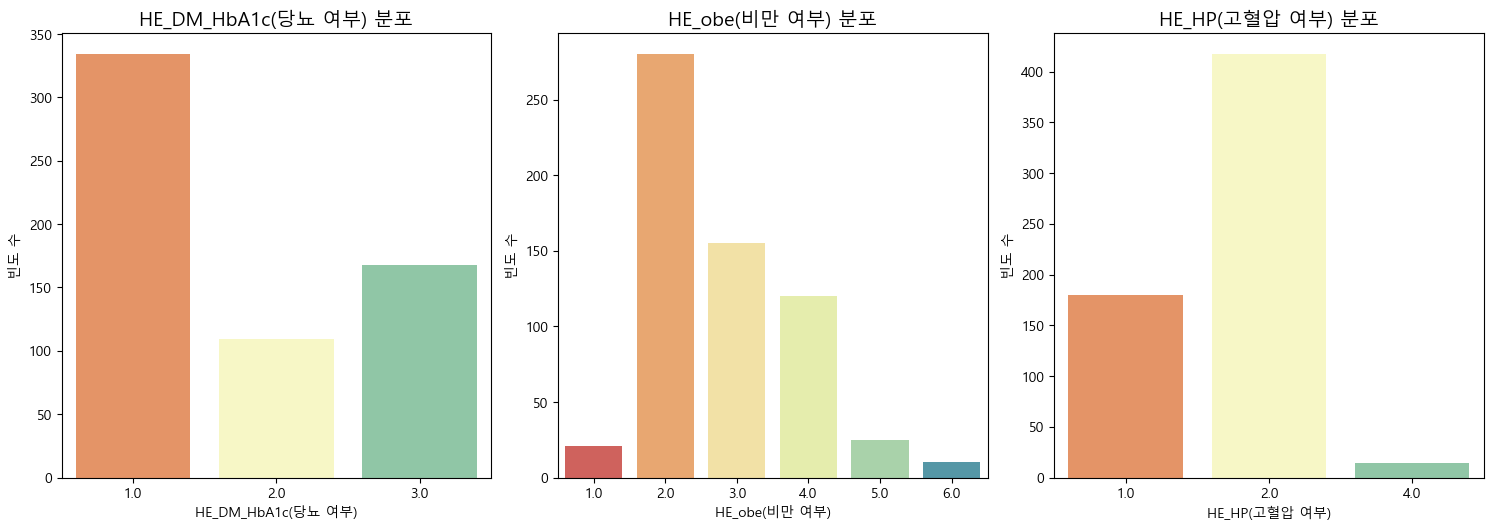

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': 'HE_DM_HbA1c(당뇨 여부)',
    'HE_obe': 'HE_obe(비만 여부)',
    'HE_HP': 'HE_HP(고혈압 여부)'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


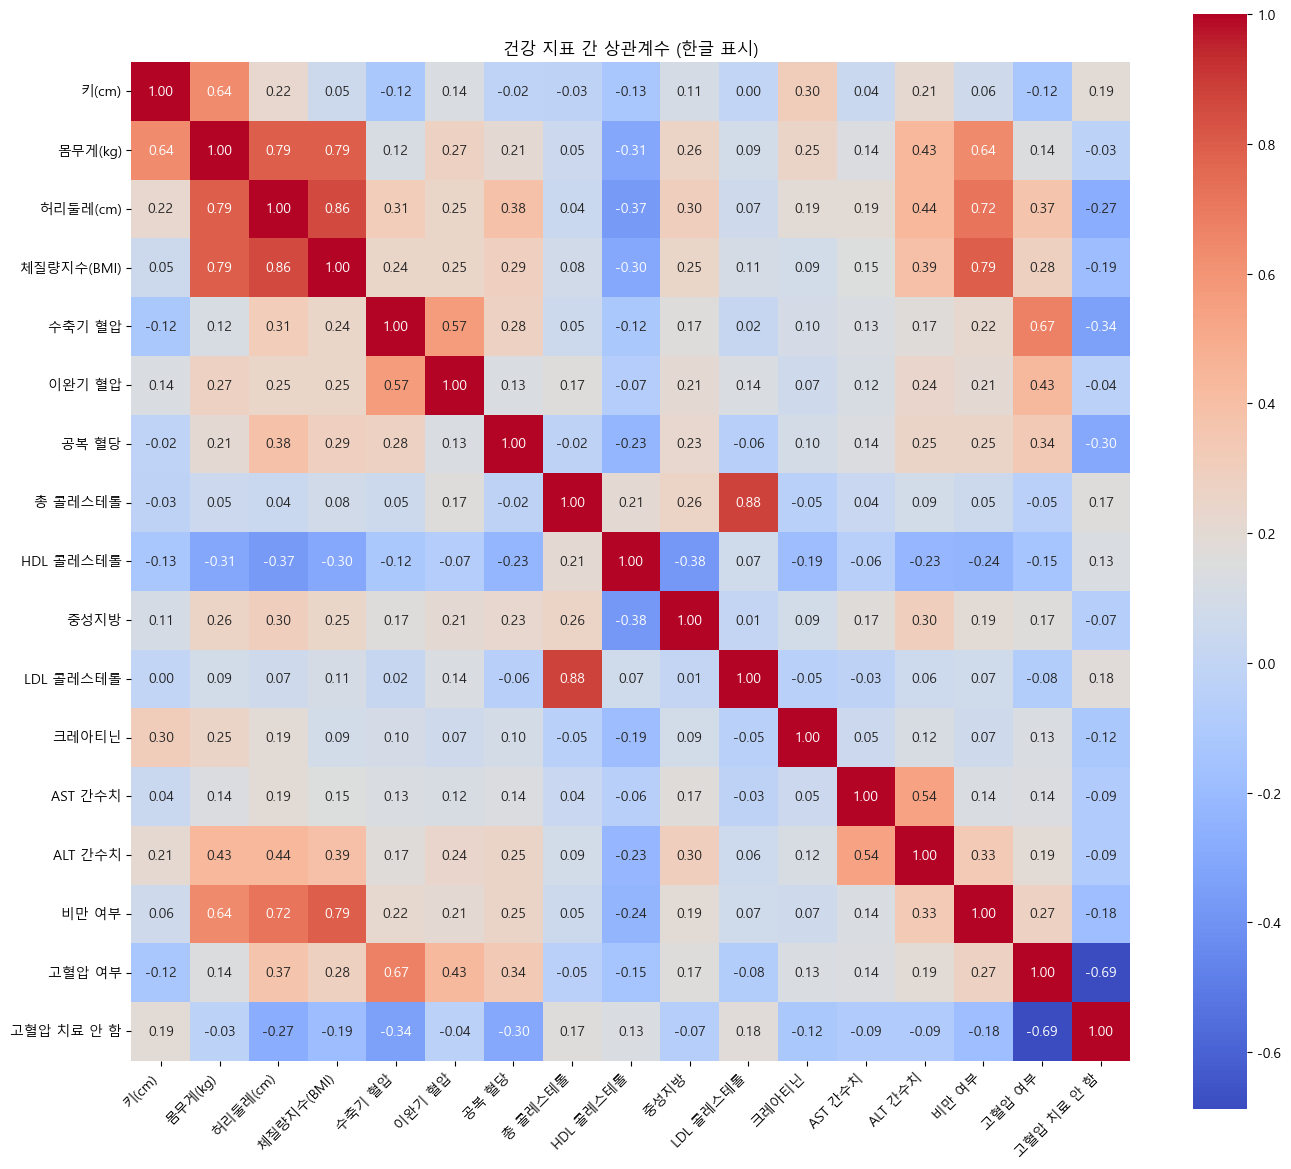

In [55]:
column_name_map = {
    'HE_ht': '키(cm)',
    'HE_wt': '몸무게(kg)',
    'HE_wc': '허리둘레(cm)',
    'HE_BMI': '체질량지수(BMI)',
    'HE_sbp1': '수축기 혈압',
    'HE_dbp1': '이완기 혈압',
    'HE_glu': '공복 혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤',
    'HE_TG': '중성지방',
    'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌',
    'HE_ast': 'AST 간수치',
    'HE_alt': 'ALT 간수치',
    'HE_obe': '비만 여부',
    'HE_HP': '고혈압 여부',
    'DI1_pt' : '고혈압 치료 안 함'
}


correlation_columns = [
    'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'DI1_pt'
]

import seaborn as sns
import matplotlib.pyplot as plt

# 보고 싶은 변수만 추출
selected_columns = list(column_name_map.keys())
correlation_matrix = data[selected_columns].corr()

# 컬럼명을 한글로 변환
correlation_matrix.columns = [column_name_map[col] for col in correlation_matrix.columns]
correlation_matrix.index = [column_name_map[col] for col in correlation_matrix.index]

# 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("건강 지표 간 상관계수 (한글 표시)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

📊 타겟 변수 상관 분석 - 고혈압압


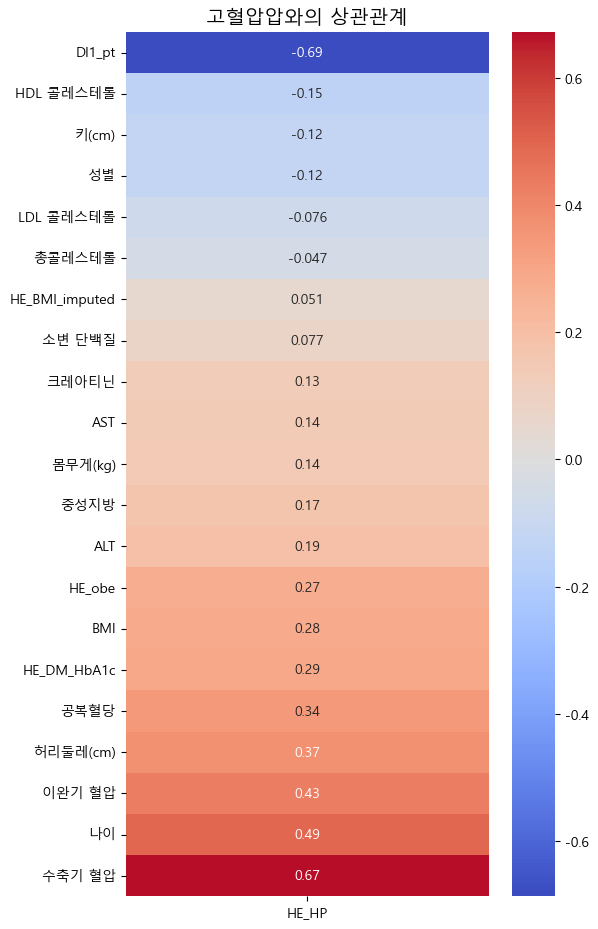

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# 변수 이름 -> 한글 매핑 사전
feature_name_ko = {
    'HE_ht': '키(cm)', 'HE_wt': '몸무게(kg)', 'HE_wc': '허리둘레(cm)', 'HE_BMI': 'BMI',
    'HE_sbp1': '수축기 혈압', 'HE_dbp1': '이완기 혈압',
    'HE_Upro': '소변 단백질', 'HE_glu': '공복혈당', 'HE_chol': '총콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤', 'HE_TG': '중성지방', 'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌', 'HE_ast': 'AST', 'HE_alt': 'ALT',
    'sex': '성별', 'age': '나이',
    'DE1_3' : '당뇨뇨 치료 안 함'
}

# 타겟 이름 -> 한글 매핑
target_name_ko = {

    'HE_HP': '고혈압압'
}

# 제외할 컬럼
exclude_cols = ['year', 'ID', 'DE1_dg', 'DI1_dg'] + list(target_name_ko.keys())

# input features 자동 지정
input_features = [col for col in data.columns if col not in exclude_cols]

for target in target_name_ko.keys():
    print(f"📊 타겟 변수 상관 분석 - {target_name_ko[target]}")
    
    # 수치형 변수만 포함한 데이터프레임
    subset = data[input_features + [target]].copy()
    subset = subset.select_dtypes(include='number')

    # 상관계수 계산
    corr_with_target = subset.corr()[[target]].drop(index=target)
    corr_with_target = corr_with_target.sort_values(by=target, ascending=True)

    # 한글 라벨로 인덱스 변환
    corr_with_target.index = [feature_name_ko.get(col, col) for col in corr_with_target.index]

    # 시각화
    plt.figure(figsize=(6, len(corr_with_target) * 0.4 + 1))
    sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', center=0)
    plt.title(f"{target_name_ko[target]}와의 상관관계", fontsize=14)
    plt.tight_layout()
    plt.show()


가설 : 기존 데이터셋에는 고혈압인데 고혈압 압치료한 사람의 수치가 껴있어 변수들간에 상관계수를 방해한다. 상관계수를 확인해 보니 기존 데이터셋과 다를것이 없다.

당뇨인데 당뇨 관리 안 한 사람 특징 보기

In [30]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2022년~2023년/건강조사_2012~2022_통합.csv") # 당뇨 치료

In [ ]:
# 당뇨뇨 전단계 또는 당뇨이면서 치료 안 한 사람만 남김
data = data[(data['HE_DM_HbA1c'].isin([2, 3])) & (data['DE1_3'] == 2)]

In [32]:
import pandas as pd

# 남기고 싶은 컬럼 리스트
columns_to_keep = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    # 'L_OUT_FQ', 
    # 'BP1','BD1_11', 'BS3_2', 'BE5_1', 
    'HE_obe', 'HE_HP', 'HE_DM_HbA1c',
    'DE1_dg', 'DI1_dg',
    'DE1_3'
]

# 원래 데이터프레임이 df일 때
data = data[columns_to_keep]

In [33]:
def iqr_clip(series, lower_quantile=0.25, upper_quantile=0.75, clip_range=1.5):
    q1 = series.quantile(lower_quantile)
    q3 = series.quantile(upper_quantile)
    iqr = q3 - q1
    lower_bound = q1 - clip_range * iqr
    upper_bound = q3 + clip_range * iqr
    return series.clip(lower=lower_bound, upper=upper_bound)

# 적용
data['HE_glu'] = iqr_clip(data['HE_glu'])
data['HE_alt'] = iqr_clip(data['HE_alt'])

# HE_DM_HbA1c
if 'HE_DM_HbA1c' in data.columns:
    data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DE1_dg' in data.columns:
        print(f"DE1_dg missing ratio: {data['DE1_dg'].isnull().mean()}")
        data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].fillna(data['DE1_dg'].map({0: 1, 1: 3}))
    # 남은 결측치는 드랍랍
    if data['HE_DM_HbA1c'].isnull().any():
        data = data[data['HE_DM_HbA1c'].notnull()]
    print(f"HE_DM_HbA1c NaN count after: {data['HE_DM_HbA1c'].isnull().sum()}")

# HE_obe
if 'HE_obe' in data.columns:
    data['HE_obe'] = data['HE_obe'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'HE_BMI' in data.columns:
        # BMI가 KNN 대체된 경우 표시
        data['HE_BMI_imputed'] = data['HE_BMI'].isnull().astype(int)
        data['HE_obe'] = data.apply(
            lambda row: row['HE_obe'] if pd.notna(row['HE_obe']) else (
                1 if row['HE_BMI'] < 18.5 else
                2 if row['HE_BMI'] < 25 else
                3 if row['HE_BMI'] < 30 else
                4 if row['HE_BMI'] < 35 else
                5 if row['HE_BMI'] < 40 else
                6
            ),
            axis=1
        )
    # 남은 결측치는 드랍랍
    if data['HE_obe'].isnull().any():
        data = data[data['HE_obe'].notnull()]
    print(f"HE_obe NaN count after: {data['HE_obe'].isnull().sum()}")

# HE_HP
if 'HE_HP' in data.columns:
    data['HE_HP'] = data['HE_HP'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DI1_dg' in data.columns:
        print(f"DI1_dg missing ratio: {data['DI1_dg'].isnull().mean()}")
        data['HE_HP'] = data['HE_HP'].fillna(data['DI1_dg'].map({0: 1, 1: 4}))
    # 남은 결측치는 드랍랍
    if data['HE_HP'].isnull().any():
        data = data[data['HE_HP'].notnull()]
    print(f"HE_HP NaN count after: {data['HE_HP'].isnull().sum()}")


#결측치 비율 낮은 변수 처리
# low_missing_columns = [
#     'DI1_dg', 
#     'DE1_dg', 
# ]
continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data



DE1_dg missing ratio: 0.0
HE_DM_HbA1c NaN count after: 0
HE_obe NaN count after: 0
DI1_dg missing ratio: 0.0
HE_HP NaN count after: 0
Median for HE_wt: 66.95
Median for HE_ht: 165.45
Median for HE_BMI: 24.470036673882998


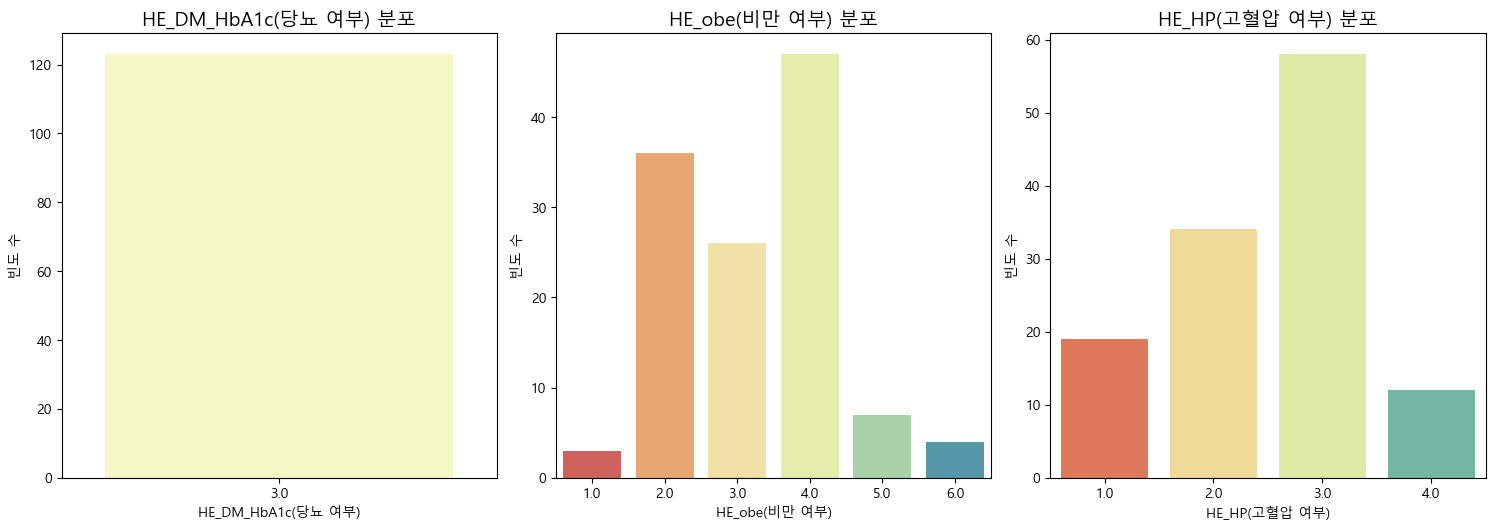

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': 'HE_DM_HbA1c(당뇨 여부)',
    'HE_obe': 'HE_obe(비만 여부)',
    'HE_HP': 'HE_HP(고혈압 여부)'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


결과 : 경계형 당뇨인 사람은 대부분 치료를 하고 있더라는 뜻

당뇨인데 치료 안 한 사람을 드랍

In [35]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2022년~2023년/건강조사_2012~2022_통합.csv") # 당뇨 치료

In [36]:
# 당뇨병이거나 전단계인데 치료를 하고 있는 사람은 제거
data = data[~((data['HE_DM_HbA1c'].isin([2, 3])) & (data['DE1_3'] == 1))]

In [37]:
import pandas as pd

# 남기고 싶은 컬럼 리스트
columns_to_keep = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    # 'L_OUT_FQ', 
    # 'BP1','BD1_11', 'BS3_2', 'BE5_1', 
    'HE_obe', 'HE_HP', 'HE_DM_HbA1c',
    'DE1_dg', 'DI1_dg',
    'DE1_3'
]

# 원래 데이터프레임이 df일 때
data = data[columns_to_keep]

In [38]:
def iqr_clip(series, lower_quantile=0.25, upper_quantile=0.75, clip_range=1.5):
    q1 = series.quantile(lower_quantile)
    q3 = series.quantile(upper_quantile)
    iqr = q3 - q1
    lower_bound = q1 - clip_range * iqr
    upper_bound = q3 + clip_range * iqr
    return series.clip(lower=lower_bound, upper=upper_bound)

# 적용
data['HE_glu'] = iqr_clip(data['HE_glu'])
data['HE_alt'] = iqr_clip(data['HE_alt'])

# HE_DM_HbA1c
if 'HE_DM_HbA1c' in data.columns:
    data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DE1_dg' in data.columns:
        print(f"DE1_dg missing ratio: {data['DE1_dg'].isnull().mean()}")
        data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].fillna(data['DE1_dg'].map({0: 1, 1: 3}))
    # 남은 결측치는 드랍랍
    if data['HE_DM_HbA1c'].isnull().any():
        data = data[data['HE_DM_HbA1c'].notnull()]
    print(f"HE_DM_HbA1c NaN count after: {data['HE_DM_HbA1c'].isnull().sum()}")

# HE_obe
if 'HE_obe' in data.columns:
    data['HE_obe'] = data['HE_obe'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'HE_BMI' in data.columns:
        # BMI가 KNN 대체된 경우 표시
        data['HE_BMI_imputed'] = data['HE_BMI'].isnull().astype(int)
        data['HE_obe'] = data.apply(
            lambda row: row['HE_obe'] if pd.notna(row['HE_obe']) else (
                1 if row['HE_BMI'] < 18.5 else
                2 if row['HE_BMI'] < 25 else
                3 if row['HE_BMI'] < 30 else
                4 if row['HE_BMI'] < 35 else
                5 if row['HE_BMI'] < 40 else
                6
            ),
            axis=1
        )
    # 남은 결측치는 드랍랍
    if data['HE_obe'].isnull().any():
        data = data[data['HE_obe'].notnull()]
    print(f"HE_obe NaN count after: {data['HE_obe'].isnull().sum()}")

# HE_HP
if 'HE_HP' in data.columns:
    data['HE_HP'] = data['HE_HP'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DI1_dg' in data.columns:
        print(f"DI1_dg missing ratio: {data['DI1_dg'].isnull().mean()}")
        data['HE_HP'] = data['HE_HP'].fillna(data['DI1_dg'].map({0: 1, 1: 4}))
    # 남은 결측치는 드랍랍
    if data['HE_HP'].isnull().any():
        data = data[data['HE_HP'].notnull()]
    print(f"HE_HP NaN count after: {data['HE_HP'].isnull().sum()}")


#결측치 비율 낮은 변수 처리
# low_missing_columns = [
#     'DI1_dg', 
#     'DE1_dg', 
# ]
continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data



DE1_dg missing ratio: 0.05828055847617185
HE_DM_HbA1c NaN count after: 0
HE_obe NaN count after: 0
DI1_dg missing ratio: 0.0
HE_HP NaN count after: 0
Median for HE_wt: 62.1
Median for HE_ht: 162.6
Median for HE_BMI: 23.61548947203167


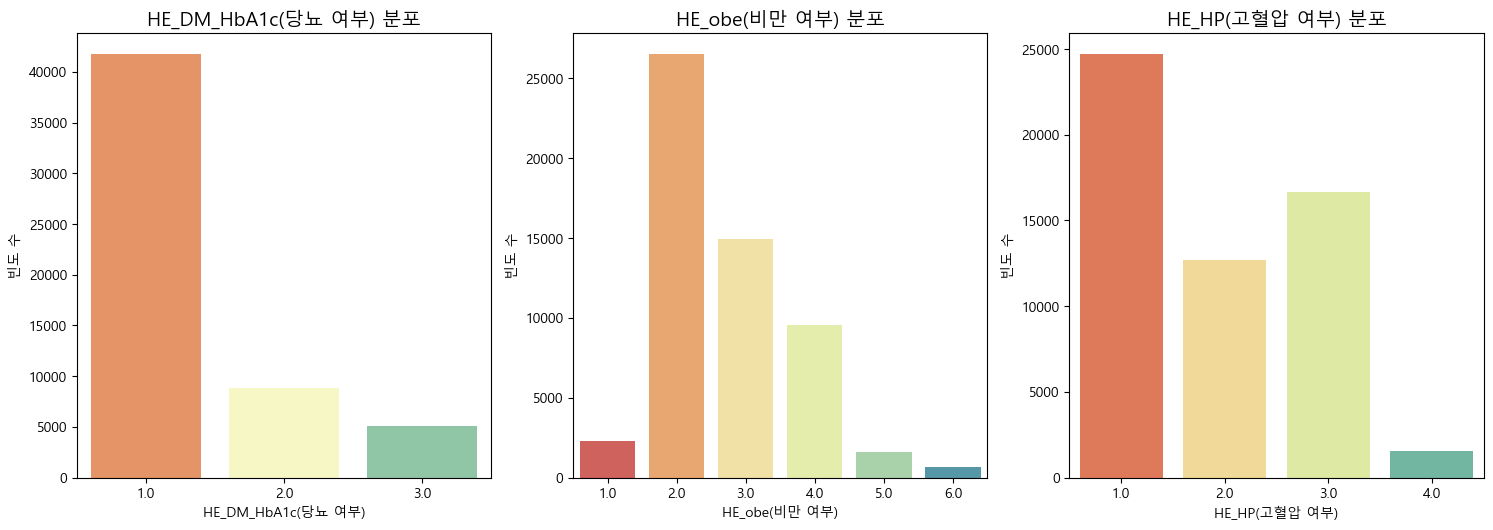

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': 'HE_DM_HbA1c(당뇨 여부)',
    'HE_obe': 'HE_obe(비만 여부)',
    'HE_HP': 'HE_HP(고혈압 여부)'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


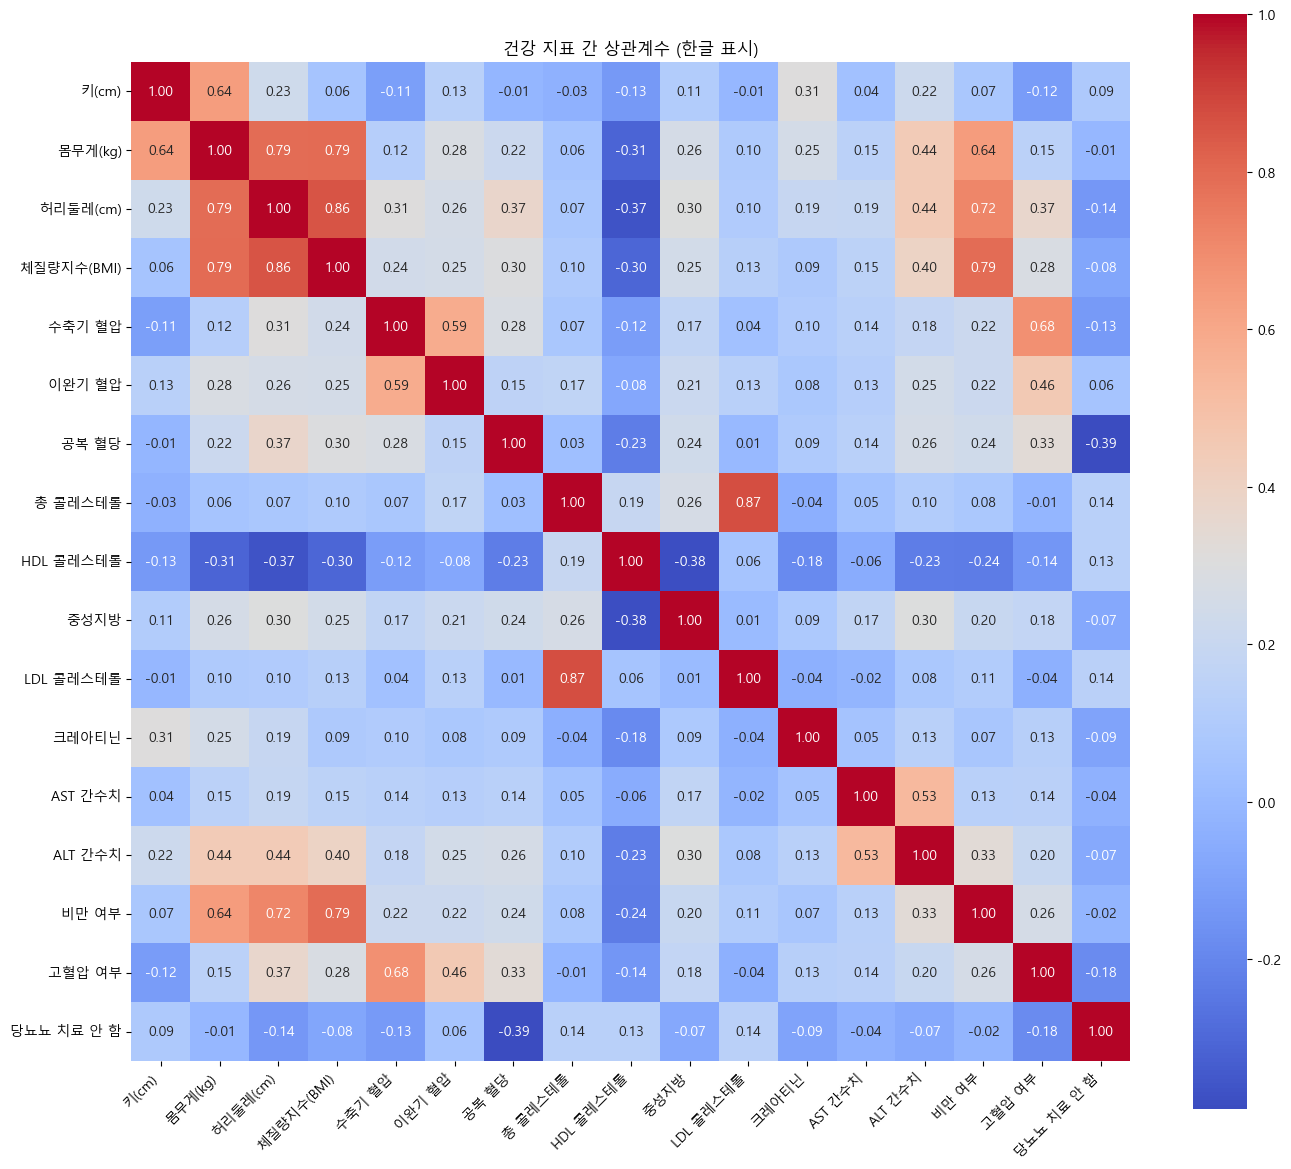

In [40]:
column_name_map = {
    'HE_ht': '키(cm)',
    'HE_wt': '몸무게(kg)',
    'HE_wc': '허리둘레(cm)',
    'HE_BMI': '체질량지수(BMI)',
    'HE_sbp1': '수축기 혈압',
    'HE_dbp1': '이완기 혈압',
    'HE_glu': '공복 혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤',
    'HE_TG': '중성지방',
    'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌',
    'HE_ast': 'AST 간수치',
    'HE_alt': 'ALT 간수치',
    'HE_obe': '비만 여부',
    'HE_HP': '고혈압 여부',
    'DE1_3' : '당뇨뇨 치료 안 함'
}


correlation_columns = [
    'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'DE1_3'
]

import seaborn as sns
import matplotlib.pyplot as plt

# 보고 싶은 변수만 추출
selected_columns = list(column_name_map.keys())
correlation_matrix = data[selected_columns].corr()

# 컬럼명을 한글로 변환
correlation_matrix.columns = [column_name_map[col] for col in correlation_matrix.columns]
correlation_matrix.index = [column_name_map[col] for col in correlation_matrix.index]

# 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("건강 지표 간 상관계수 (한글 표시)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

📊 타겟 변수 상관 분석 - 당뇨병


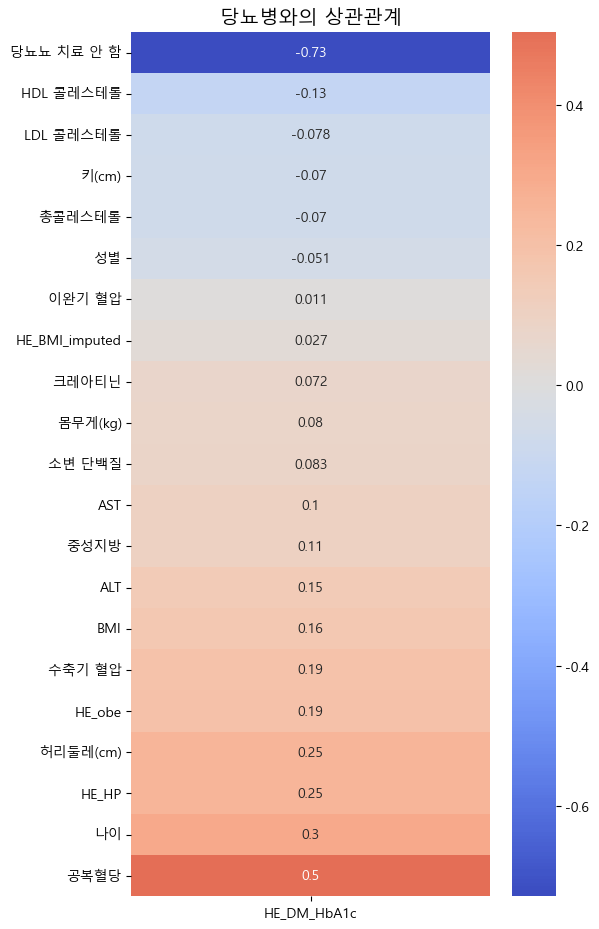

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# 변수 이름 -> 한글 매핑 사전
feature_name_ko = {
    'HE_ht': '키(cm)', 'HE_wt': '몸무게(kg)', 'HE_wc': '허리둘레(cm)', 'HE_BMI': 'BMI',
    'HE_sbp1': '수축기 혈압', 'HE_dbp1': '이완기 혈압',
    'HE_Upro': '소변 단백질', 'HE_glu': '공복혈당', 'HE_chol': '총콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤', 'HE_TG': '중성지방', 'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌', 'HE_ast': 'AST', 'HE_alt': 'ALT',
    'sex': '성별', 'age': '나이',
    'DE1_3' : '당뇨뇨 치료 안 함'
}

# 타겟 이름 -> 한글 매핑
target_name_ko = {

    'HE_DM_HbA1c': '당뇨병'
}

# 제외할 컬럼
exclude_cols = ['year', 'ID', 'DE1_dg', 'DI1_dg'] + list(target_name_ko.keys())

# input features 자동 지정
input_features = [col for col in data.columns if col not in exclude_cols]

for target in target_name_ko.keys():
    print(f"📊 타겟 변수 상관 분석 - {target_name_ko[target]}")
    
    # 수치형 변수만 포함한 데이터프레임
    subset = data[input_features + [target]].copy()
    subset = subset.select_dtypes(include='number')

    # 상관계수 계산
    corr_with_target = subset.corr()[[target]].drop(index=target)
    corr_with_target = corr_with_target.sort_values(by=target, ascending=True)

    # 한글 라벨로 인덱스 변환
    corr_with_target.index = [feature_name_ko.get(col, col) for col in corr_with_target.index]

    # 시각화
    plt.figure(figsize=(6, len(corr_with_target) * 0.4 + 1))
    sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', center=0)
    plt.title(f"{target_name_ko[target]}와의 상관관계", fontsize=14)
    plt.tight_layout()
    plt.show()


가설 : 기존 데이터셋에는 당뇨인데 당뇨뇨치료한 사람의 수치가 껴있어 변수들간에 상관계수를 방해한다. 상관계수를 확인해 보니 기존 데이터셋과 다를것이 없다.

**전체년도 모델 테스트**

In [16]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2012년~2023년/건강조사_2012~2023.csv")

In [7]:
data.shape

(91028, 1477)

EDA

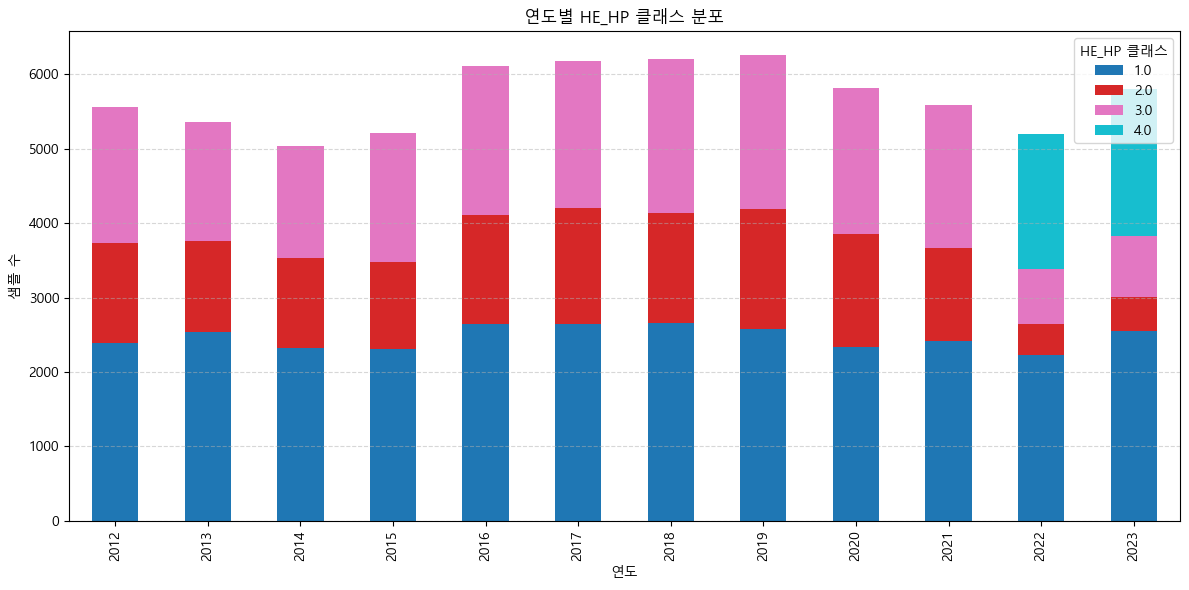

HE_HP   1.0   2.0   3.0   4.0
year                         
2012   2394  1341  1830     0
2013   2543  1215  1594     0
2014   2325  1201  1505     0
2015   2304  1174  1726     0
2016   2641  1469  1995     0
2017   2646  1554  1978     0
2018   2659  1480  2061     0
2019   2571  1615  2075     0
2020   2329  1520  1960     0
2021   2416  1252  1924     0
2022   2223   418   737  1824
2023   2549   464   815  1979


In [70]:
import pandas as pd
import matplotlib.pyplot as plt


# 연도별 HE_HP 분포 계산
year_class_counts = data.groupby("year")["HE_HP"].value_counts().unstack(fill_value=0)

# 히트맵 또는 스택 바차트로 시각화
year_class_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab10")
plt.title("연도별 HE_HP 클래스 분포")
plt.xlabel("연도")
plt.ylabel("샘플 수")
plt.legend(title="HE_HP 클래스")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 수치 확인
print(year_class_counts)

의료 기준이 바뀌었거나, 고도 고혈압 등 추가 세분화된 분류가 생긴 것

즉, 2012–2021년 데이터엔 원래부터 Class 4가 없었던 것 → 정상입니다

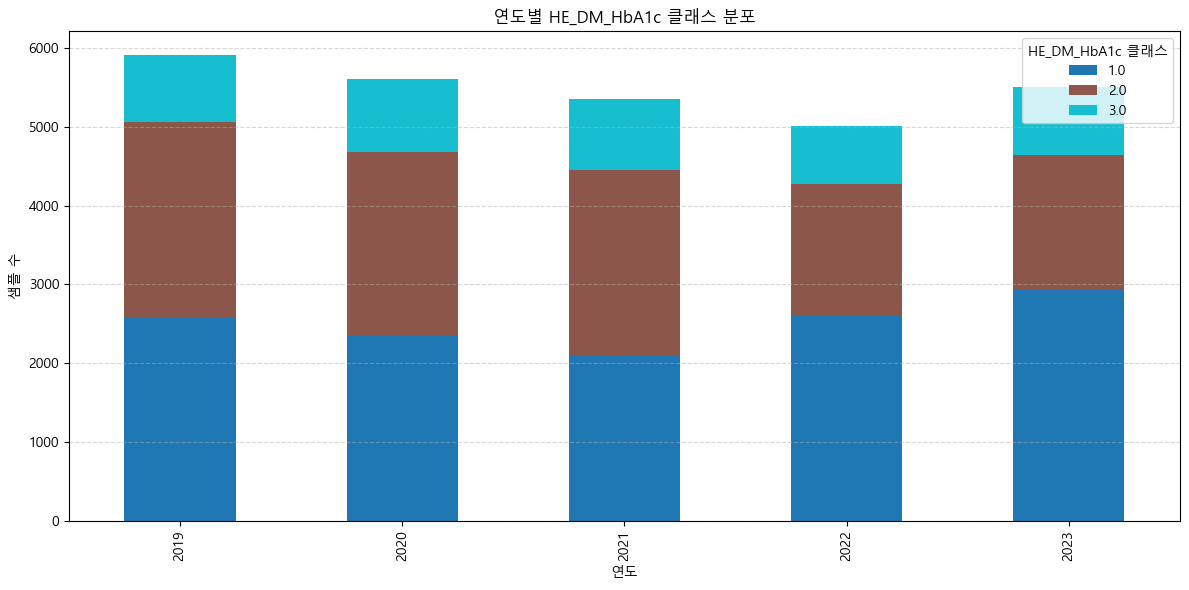

HE_DM_HbA1c   1.0   2.0  3.0
year                        
2019         2583  2480  851
2020         2357  2319  936
2021         2101  2347  899
2022         2614  1655  738
2023         2925  1719  860


In [71]:
import pandas as pd
import matplotlib.pyplot as plt


# 연도별 HE_HP 분포 계산
year_class_counts = data.groupby("year")["HE_DM_HbA1c"].value_counts().unstack(fill_value=0)

# 히트맵 또는 스택 바차트로 시각화
year_class_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab10")
plt.title("연도별 HE_DM_HbA1c 클래스 분포")
plt.xlabel("연도")
plt.ylabel("샘플 수")
plt.legend(title="HE_DM_HbA1c 클래스")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 수치 확인
print(year_class_counts)

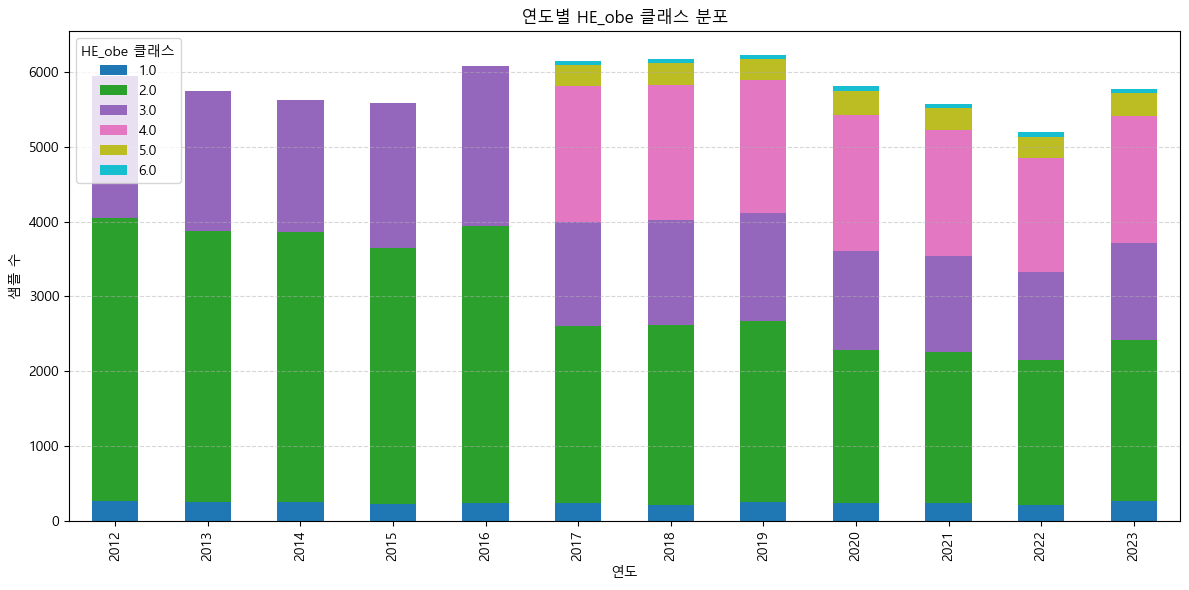

HE_obe  1.0   2.0   3.0   4.0  5.0  6.0
year                                   
2012    267  3778  1897     0    0    0
2013    257  3620  1871     0    0    0
2014    248  3609  1775     0    0    0
2015    221  3423  1948     0    0    0
2016    234  3709  2135     0    0    0
2017    244  2368  1389  1817  281   51
2018    215  2400  1413  1801  296   45
2019    249  2430  1432  1778  288   55
2020    240  2044  1330  1811  326   64
2021    244  2015  1281  1684  297   53
2022    207  1950  1175  1521  285   59
2023    264  2156  1293  1707  304   56


In [72]:
import pandas as pd
import matplotlib.pyplot as plt


# 연도별 HE_HP 분포 계산
year_class_counts = data.groupby("year")["HE_obe"].value_counts().unstack(fill_value=0)

# 히트맵 또는 스택 바차트로 시각화
year_class_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab10")
plt.title("연도별 HE_obe 클래스 분포")
plt.xlabel("연도")
plt.ylabel("샘플 수")
plt.legend(title="HE_obe 클래스")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 수치 확인
print(year_class_counts)

In [85]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2012년~2023년/건강조사_2022_2023_통합.csv") 

In [86]:
data.shape

(13194, 676)

In [87]:
data

,mod_d,ID,ID_fam,year,region,town_t,apt_t,psu,sex,age,age_month,incm,ho_incm,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_oe,wt_bia,wt_ntr,wt_tot,wt_oent,wt_biant,kstrata,cfam,genertn,allownc,house,live_t,ainc_unit1,ainc_1,ainc,marri_1,marri_2,fam_rela,tins,npins,ID_F,ID_M,D_1_1,D_2_1,D_2_wk,DI1_dg,DI1_ag,DI1_pr,DI1_pt,DI1_2,DI2_dg,DI2_ag,DI2_pr,DI2_pt,DI2_2,DE1_dg,DE1_ag,DE1_pr,DE1_pt,DE1_3,DE1_31,DE1_32,DE1_33,DE1_34,DE1_35,DE1_4,DJ4_dg,DJ4_ag,DJ4_3,DL1_dg,DL1_ag,DJ8_dg,DJ8_ag,DJ6_dg,DJ6_ag,DH4_dg,DH4_ag,DN1_dg,DN1_ag,BP17_dg,BH9_11,BH1,BH2_61,AC1_yr,AC3,AC3_1_01,AC3_1_02,AC3_1_03,AC3_2_01,AC3_2_02,AC3_2_03,AC8_1_01,AC8_1_02,AC8_1_03,AC8_1e_01,AC8_1e_02,AC8_1e_03,AC8_2w_01,AC8_2w_02,AC8_2w_03,AC8_2_01,AC8_2_02,AC8_2_03,AC8_3w_01,AC8_3w_02,AC8_3w_03,AC8_3_01,AC8_3_02,AC8_3_03,ij_expr,educ,graduat,EC_pedu_1,EC_pedu_2,CH2_1,CH2_2,EC1_1,EC_occp,EC_stt_1,EC_stt_2,EC_wht_0,EC_wht_23,EC_lgw_2,EC_lgw_4,EC_lgw_5,BO1,BO1_1,BO1_2,BO1_3,BO2_1,BO3_01,BO3_02,BO3_03,BO3_14,BO3_05,BO3_04,BO3_12,BO3_07,BO3_09,BO3_10,BO3_11,BD1,BD2,BD1_11,BD2_1,BD2_14,BD2_31,BD2_32,BD7_4,BD7_5,BD7_61,BD7_62,BD7_63,BD7_64,BD7_65,BD7_66,BD7_67,dr_month,BA2_12,BA2_13,BA2_14,BA2_2_1,BA2_2_2,BA2_2_3,BA2_2_4,BA2_2_5,BA2_2_6,BA2_22,BA1_1,BA1_3,BA1_2,sc_seatblt,sc_seatblt2,sc_seatblt3,BP16_1,BP16_2,BP17_2,BP17_3,BP17_4,BP_PHQ_1,BP_PHQ_2,BP_PHQ_3,BP_PHQ_4,BP_PHQ_5,BP_PHQ_6,BP_PHQ_7,BP_PHQ_8,BP_PHQ_9,mh_PHQ_S,BP_GAD_1,BP_GAD_2,BP_GAD_3,BP_GAD_4,BP_GAD_5,BP_GAD_6,BP_GAD_7,mh_GAD_S,BP1,BP5,BP6_10,BP6_2,BP6_31,BP7,mh_stress,BS1_1,BS2_1,BS3_1,BS3_2,BS3_3,BS6_2,BS6_2_1,BS6_2_2,BS6_3,BS6_4,BS6_4_1,BS6_4_2,BS12_37,BS12_47,BS12_47_1,BS12_47_2,BS12_1,BS12_2,BS12_31,BS12_32,BS12_33,BS12_34,BS12_35,BS12_36,BS12_41,BS12_42,BS12_43,BS12_44,BS12_45,BS12_46,BS5_4,BS5,BS5_1,BS5_21,BS5_28,BS5_26,BS5_33,BS5_34,BS5_32,BS5_29,BS5_30,BS5_31,BS8_2,BS9_2,BS13,BS10_1,BS2,BS10_2,BS10_3,sm_presnt,BE3_71,BE3_72,BE3_73,BE3_74,BE3_81,BE3_82,BE3_83,BE3_84,BE3_91,BE3_92,BE3_93,BE3_94,BE3_75,BE3_76,BE3_77,BE3_78,BE3_85,BE3_86,BE3_87,BE3_88,BE8_1,BE8_2,BE3_31,BE3_32,BE3_33,BE5_1,BE9,pa_aerobic,LW_ms,LW_mp_e,LW_mp_a,LW_ms_a,LW_pr,LW_pr_1,LW_mt,LW_mt_a1,LW_mt_a2,LW_br,LW_br_ch,LW_br_dur,LW_br_yy,LW_br_mm,LW_oc,HE_fst,HE_mens,HE_prg,HE_dprg,HE_fh,HE_HPfh1,HE_HPfh2,HE_HPfh3,HE_HLfh1,HE_HLfh2,HE_HLfh3,HE_IHDfh1,HE_IHDfh2,HE_IHDfh3,HE_STRfh1,HE_STRfh2,HE_STRfh3,HE_DMfh1,HE_DMfh2,HE_DMfh3,HE_rPLS,HE_PLS_30,HE_mPLS,HE_nARM,HE_sbp1,HE_dbp1,HE_sbp2,HE_dbp2,HE_sbp3,HE_dbp3,HE_sbp,HE_dbp,HE_HP,HE_ht,HE_wt,HE_wc,HE_nc,HE_BMI,HE_obe,HE_wt_pct,HE_BMI_pct,HE_glu,HE_HbA1c,HE_DM_HbA1c,HE_chol,HE_HDL_st2,HE_TG,HE_LDL_drct,HE_HCHOL,HE_HTG,HE_ast,HE_alt,HE_alt_etc,HE_hepaB,HE_hepaC,HE_HB,HE_HCT,HE_anem,HE_BUN,HE_crea,HE_WBC,HE_RBC,HE_Bplt,HE_Uacid,HE_hsCRP,HE_hsCRP_etc,HE_D2,HE_D2_etc,HE_D3,HE_D3_3epi,HE_D3_3epi_etc,HE_Uph,HE_Unitr,HE_Usg,HE_Upro,HE_Uglu,HE_Uket,HE_Ubil,HE_Ubld,HE_Uro,HE_Ucrea,HE_UNa,HE_UNa_etc,HE_Ualb,HE_Ualb_etc,HE_Ukal,HE_Ukal_etc,O_TC,O_PROS_U,O_PROS_L,O_IMP_UI,O_IMP_UM,O_IMP_LI,O_IMP_LM,O_BR_N_U,O_BR_N_L,O_DENT_U,O_DENT_L,O_F,OR1,O_pain,O_ortho,BM1_0,BM1_1,BM1_2,BM1_3,BM1_4,BM1_5,BM1_6,BM1_7,BM1_8,BM2_1,BM2_3,BM2_2,BM2_4,BM2_5,BM13,BM13_1,BM13_2,BM13_3,BM13_4,BM13_5,BM13_6,BM7,O_chew_d,BM8,OR1_2,MO4_00,MO4_4,MO4_9,MO4_7,MO4_8,MO4_17_1,MO4_17_2,MO4_11,MO4_12,MO4_18,MO4_15,BM14,BM14_1,BM14_2,GS_use,GS_mea_r_1,GS_mea_r_2,GS_mea_l_1,GS_mea_l_2,BIA_ex,BIA_FFM,BIA_LRA,BIA_LLA,BIA_LRL,BIA_LLL,BIA_BFM,BIA_PBF,BIA_FRA,BIA_FLA,BIA_FT,BIA_FRL,BIA_FLL,BIA_TBW,BIA_ICW,BIA_ECW,BIA_WBPA50,T_ex,T_Q_HR,T_Q_HR_1,T_Q_HR_2,T_NQ_OCP,T_NQ_PH2,T_NQ_PH2_T,T_Q_VN,T_Q_VN_1,T_Q_VN_2,T_Q_DZ,T_Q_DZ2,T_Q_DZ3,T_Q_DZ4,T_Q_DZ5,T_Q_DZ6,T_Q_DZ7,T_Q_CR,T_Q_CR1,T_Q_CR2,T_Q_CR3,T_Q_CR4,T_Q_ALLE,T_Q_SNST1,T_Q_SNST2,T_Q_SNST3,T_Q_SNST4,T_Q_SINU,T_Q_SINU_1,T_Q_VC,T_Q_VC1,T_HR_EX_R,T_HR_EX_R_1,T_HR_EX_L,T_HR_EX_L_1,T_HR500_pass,T_HR1000_pass,T_HR2000_pass,T_HR4000_pass,T_HR500_RT,T_HR1000_RT,T_HR2000_RT,T_HR4000_RT,T_HR8000_RT,T_HR500_LT,T_HR1000_LT,T_HR2000_LT,T_HR4000_LT,T_HR8000_LT,T_HL_mod,T_HL_mild,T_IM_EX_R,T_IM_EX_R_1,T_IM_EX_L,T_IM_EX_L

In [88]:
import pandas as pd

# 남기고 싶은 컬럼 리스트
columns_to_keep = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu', 'HE_chol', 'HE_HDL_st2', 'HE_HbA1c',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    'HE_obe', 'HE_HP', 'HE_DM_HbA1c',
    'DE1_dg', 'DI1_dg',
]

# 원래 데이터프레임이 df일 때
data = data[columns_to_keep]


In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13194 entries, 0 to 13193
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           13194 non-null  object 
 1   year         13194 non-null  float64
 2   age          13194 non-null  float64
 3   sex          13194 non-null  float64
 4   HE_ht        12964 non-null  float64
 5   HE_wt        13104 non-null  float64
 6   HE_wc        12285 non-null  float64
 7   HE_BMI       12959 non-null  float64
 8   HE_sbp1      12490 non-null  float64
 9   HE_dbp1      12490 non-null  float64
 10  HE_Upro      11828 non-null  float64
 11  HE_glu       11744 non-null  float64
 12  HE_chol      11744 non-null  float64
 13  HE_HDL_st2   11744 non-null  float64
 14  HE_HbA1c     11710 non-null  float64
 15  HE_TG        11744 non-null  float64
 16  HE_LDL_drct  11744 non-null  float64
 17  HE_crea      11744 non-null  float64
 18  HE_ast       11743 non-null  float64
 19  HE_a

In [10]:
column_mapping = {
    'ID': 'ID',
    'year': 'year(조사연도)',
    'age': 'age(연령)',
    'sex': 'sex(성별)',
    'HE_ht': 'HE_ht(신장(cm))',
    'HE_wt': 'HE_wt(체중(kg))',
    'HE_wc': 'HE_wc(허리둘레(cm))',
    'HE_BMI': 'HE_BMI(체질량지수)',
    'HE_sbp1': 'HE_sbp1(수축기 혈압)',
    'HE_dbp1': 'HE_dbp1(이완기 혈압)',
    'HE_Upro': 'HE_Upro(소변 단백)',
    'HE_glu': 'HE_glu(공복혈당)',
    'HE_HbA1c' : 'HE_HbA1c(당화혈색소)',
    'HE_chol': 'HE_chol(총 콜레스테롤)',
    'HE_HDL_st2': 'HE_HDL_st2(HDL 콜레스테롤)',
    'HE_TG': 'HE_TG(중성지방)',
    'HE_LDL_drct': 'HE_LDL_drct(LDL 콜레스테롤)',
    'HE_crea': 'HE_crea(크레아티닌)',
    'HE_ast': 'HE_ast(AST (간기능))',
    'HE_alt': 'HE_alt(ALT (간기능))',
    'HE_obe': 'HE_obe(비만 여부)',
    'HE_HP': 'HE_HP(고혈압 여부)',
    'DI1_dg': 'DI1_dg(고혈압 의사진단 여부)',
    'HE_DM_HbA1c': 'HE_DM_HbA1c(당뇨 여부 (HbA1c))',
    'DE1_dg': 'DE1_dg(당뇨병 의사진단 여부)',
    'DE1_pt': 'DE1_pt(당뇨병치료여부)',
    'DI1_pt': 'DI1_pt(고혈압치료여부)'
    
}

# 1. 영어 컬럼 순서 (원하는 순서)
original_columns = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1','HE_Upro', 'HE_glu','HE_HbA1c', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    'HE_obe', 'HE_HP', 'DI1_dg', 'HE_DM_HbA1c','DE1_dg', 'DE1_pt', 'DI1_pt'
]

# 2. 한글 매핑된 컬럼 리스트 만들기
kor_columns = [column_mapping[col] for col in original_columns]

# 3. 컬럼명 한글로 바꾸기
data = data.rename(columns=column_mapping)

# 4. 원하는 순서로 재정렬
data = data[kor_columns]

**데이터 통계확인**

In [ ]:
data

In [11]:
data.describe()

,year(조사연도),age(연령),sex(성별),HE_ht(신장(cm)),HE_wt(체중(kg)),HE_wc(허리둘레(cm)),HE_BMI(체질량지수),HE_sbp1(수축기 혈압),HE_dbp1(이완기 혈압),HE_Upro(소변 단백),HE_glu(공복혈당),HE_HbA1c(당화혈색소),HE_chol(총 콜레스테롤),HE_HDL_st2(HDL 콜레스테롤),HE_TG(중성지방),HE_LDL_drct(LDL 콜레스테롤),HE_crea(크레아티닌),HE_ast(AST (간기능)),HE_alt(ALT (간기능)),HE_obe(비만 여부),HE_HP(고혈압 여부),DI1_dg(고혈압 의사진단 여부),HE_DM_HbA1c(당뇨 여부 (HbA1c)),DE1_dg(당뇨병 의사진단 여부),DE1_pt(당뇨병치료여부),DI1_pt(고혈압치료여부)
count,91028.000000,91028.000000,91028.000000,86573.000000,86973.000000,85125.000000,86548.000000,78843.000000,78843.000000,73887.000000,74181.000000,74006.000000,74201.000000,74189.000000,74201.000000,25389.000000,74201.000000,74200.000000,74167.000000,69910.000000,68306.000000,86260.000000,27384.000000,86260.000000,86260.000000,86260.000000
mean,2017.325460,43.727414,1.545689,157.812552,58.848904,79.182505,22.947594,119.637875,74.367325,0.160651,100.262776,5.717795,187.170146,52.277081,128.339578,113.145929,0.806015,23.072844,21.733493,2.687312,1.973736,2.217030,1.697049,1.183364,7.431324,6.569082
std,3.399379,22.740948,0.497911,18.199830,17.616049,13.433796,4.187423,17.266174,10.895144,0.470944,22.922333,0.791352,37.914666,13.030777,102.793233,35.114645,0.263779,13.997863,19.212834,0.942500,0.975244,3.391431,0.723930,2.756764,1.948556,2.860991
min,2012.000000,1.000000,1.000000,69.700000,7.369000,34.500000,9.637899,60.000000,0.000000,0.000000,40.000000,3.100000,64.000000,5.918000,9.000000,10.000000,0.200000,5.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2014.000000,25.000000,1.000000,153.300000,51.000000,71.200000,20.258022,108.000000,67.000000,0.000000,89.000000,5.300000,161.000000,43.000000,71.000000,88.000000,0.660000,17.000000,12.000000,2.000000,1.000000,0.000000,1.000000,0.000000,8.000000,8.000000
50%,2017.000000,46.000000,2.000000,160.900000,59.700000,80.200000,22.939689,118.000000,74.000000,0.000000,95.000000,5.500000,185.000000,51.000000,103.000000,111.000000,0.770000,21.000000,17.000000,2.000000,2.000000,0.000000,2.000000,0.000000,8.000000,8.000000
75%,2020.000000,62.000000,2.000000,168.700000,69.400000,88.300000,25.516647,130.000000,82.000000,0.000000,103.000000,5.900000,211.000000,60.000000,153.000000,136.000000,0.920000,25.000000,25.000000,3.000000,3.000000,8.000000,2.000000,0.000000,8.000000,8.000000
max,2023.000000,80.000000,2.000000,198.000000,164.800000,147.500000,62.640542,244.000000,152.000000,5.000000,553.000000,17.600000,525.000000,145.298000,3367.000000,394.000000,17.530000,927.000000,861.000000,6.000000,4.000000,9.000000,3.000000,9.000000,9.000000,9.000000


In [12]:
# 3️⃣ EDA 요약 (결측치, 통계값, 이상치)


# 이상치 비율 계산 함수
def detect_outlier_ratio(series):
    if series.dtype.kind in 'biufc':
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outlier_ratio = ((series < lower) | (series > upper)).mean() * 100
        return outlier_ratio
    else:
        return np.nan
    
eda = pd.DataFrame(index=data.columns)
eda['고유값 개수'] = data.nunique()
eda['결측치 비율 (%)'] = data.isnull().mean() * 100
eda['이상치 비율 (%)'] = data.apply(detect_outlier_ratio)
eda['최소값'] = data.min(numeric_only=True)
eda['최대값'] = data.max(numeric_only=True)
eda['평균'] = data.mean(numeric_only=True)
eda['표준편차'] = data.std(numeric_only=True)

eda

,고유값 개수,결측치 비율 (%),이상치 비율 (%),최소값,최대값,평균,표준편차
ID,60022,34.062047,NaN,NaN,NaN,NaN,NaN
year(조사연도),12,0.000000,0.000000,2012.000000,2023.000000,2017.325460,3.399379
age(연령),80,0.000000,0.000000,1.000000,80.000000,43.727414,22.740948
sex(성별),2,0.000000,0.000000,1.000000,2.000000,1.545689,0.497911
HE_ht(신장(cm)),1283,4.894099,7.359274,69.700000,198.000000,157.812552,18.199830
HE_wt(체중(kg)),2158,4.454673,7.053874,7.369000,164.800000,58.848904,17.616049
HE_wc(허리둘레(cm)),887,6.484818,1.486356,34.500000,147.500000,79.182505,13.433796
HE_BMI(체질량지수),65229,4.921563,1.204025,9.637899,62.640542,22.947594,4.187423
HE_sbp1(수축기 혈압),149,13.385991,1.645647,60.000000,244.000000,119.637875,17.266174
HE_dbp1(이완기 혈압),107,13.385991,0.875555,0.000000,152.000000,74.367325,10.895144


In [14]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2012년~2023년/건강조사_2022_2023_통합.csv") 

In [97]:
data

,mod_d,ID,ID_fam,year,region,town_t,apt_t,psu,sex,age,age_month,incm,ho_incm,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_oe,wt_bia,wt_ntr,wt_tot,wt_oent,wt_biant,kstrata,cfam,genertn,allownc,house,live_t,ainc_unit1,ainc_1,ainc,marri_1,marri_2,fam_rela,tins,npins,ID_F,ID_M,D_1_1,D_2_1,D_2_wk,DI1_dg,DI1_ag,DI1_pr,DI1_pt,DI1_2,DI2_dg,DI2_ag,DI2_pr,DI2_pt,DI2_2,DE1_dg,DE1_ag,DE1_pr,DE1_pt,DE1_3,DE1_31,DE1_32,DE1_33,DE1_34,DE1_35,DE1_4,DJ4_dg,DJ4_ag,DJ4_3,DL1_dg,DL1_ag,DJ8_dg,DJ8_ag,DJ6_dg,DJ6_ag,DH4_dg,DH4_ag,DN1_dg,DN1_ag,BP17_dg,BH9_11,BH1,BH2_61,AC1_yr,AC3,AC3_1_01,AC3_1_02,AC3_1_03,AC3_2_01,AC3_2_02,AC3_2_03,AC8_1_01,AC8_1_02,AC8_1_03,AC8_1e_01,AC8_1e_02,AC8_1e_03,AC8_2w_01,AC8_2w_02,AC8_2w_03,AC8_2_01,AC8_2_02,AC8_2_03,AC8_3w_01,AC8_3w_02,AC8_3w_03,AC8_3_01,AC8_3_02,AC8_3_03,ij_expr,educ,graduat,EC_pedu_1,EC_pedu_2,CH2_1,CH2_2,EC1_1,EC_occp,EC_stt_1,EC_stt_2,EC_wht_0,EC_wht_23,EC_lgw_2,EC_lgw_4,EC_lgw_5,BO1,BO1_1,BO1_2,BO1_3,BO2_1,BO3_01,BO3_02,BO3_03,BO3_14,BO3_05,BO3_04,BO3_12,BO3_07,BO3_09,BO3_10,BO3_11,BD1,BD2,BD1_11,BD2_1,BD2_14,BD2_31,BD2_32,BD7_4,BD7_5,BD7_61,BD7_62,BD7_63,BD7_64,BD7_65,BD7_66,BD7_67,dr_month,BA2_12,BA2_13,BA2_14,BA2_2_1,BA2_2_2,BA2_2_3,BA2_2_4,BA2_2_5,BA2_2_6,BA2_22,BA1_1,BA1_3,BA1_2,sc_seatblt,sc_seatblt2,sc_seatblt3,BP16_1,BP16_2,BP17_2,BP17_3,BP17_4,BP_PHQ_1,BP_PHQ_2,BP_PHQ_3,BP_PHQ_4,BP_PHQ_5,BP_PHQ_6,BP_PHQ_7,BP_PHQ_8,BP_PHQ_9,mh_PHQ_S,BP_GAD_1,BP_GAD_2,BP_GAD_3,BP_GAD_4,BP_GAD_5,BP_GAD_6,BP_GAD_7,mh_GAD_S,BP1,BP5,BP6_10,BP6_2,BP6_31,BP7,mh_stress,BS1_1,BS2_1,BS3_1,BS3_2,BS3_3,BS6_2,BS6_2_1,BS6_2_2,BS6_3,BS6_4,BS6_4_1,BS6_4_2,BS12_37,BS12_47,BS12_47_1,BS12_47_2,BS12_1,BS12_2,BS12_31,BS12_32,BS12_33,BS12_34,BS12_35,BS12_36,BS12_41,BS12_42,BS12_43,BS12_44,BS12_45,BS12_46,BS5_4,BS5,BS5_1,BS5_21,BS5_28,BS5_26,BS5_33,BS5_34,BS5_32,BS5_29,BS5_30,BS5_31,BS8_2,BS9_2,BS13,BS10_1,BS2,BS10_2,BS10_3,sm_presnt,BE3_71,BE3_72,BE3_73,BE3_74,BE3_81,BE3_82,BE3_83,BE3_84,BE3_91,BE3_92,BE3_93,BE3_94,BE3_75,BE3_76,BE3_77,BE3_78,BE3_85,BE3_86,BE3_87,BE3_88,BE8_1,BE8_2,BE3_31,BE3_32,BE3_33,BE5_1,BE9,pa_aerobic,LW_ms,LW_mp_e,LW_mp_a,LW_ms_a,LW_pr,LW_pr_1,LW_mt,LW_mt_a1,LW_mt_a2,LW_br,LW_br_ch,LW_br_dur,LW_br_yy,LW_br_mm,LW_oc,HE_fst,HE_mens,HE_prg,HE_dprg,HE_fh,HE_HPfh1,HE_HPfh2,HE_HPfh3,HE_HLfh1,HE_HLfh2,HE_HLfh3,HE_IHDfh1,HE_IHDfh2,HE_IHDfh3,HE_STRfh1,HE_STRfh2,HE_STRfh3,HE_DMfh1,HE_DMfh2,HE_DMfh3,HE_rPLS,HE_PLS_30,HE_mPLS,HE_nARM,HE_sbp1,HE_dbp1,HE_sbp2,HE_dbp2,HE_sbp3,HE_dbp3,HE_sbp,HE_dbp,HE_HP,HE_ht,HE_wt,HE_wc,HE_nc,HE_BMI,HE_obe,HE_wt_pct,HE_BMI_pct,HE_glu,HE_HbA1c,HE_DM_HbA1c,HE_chol,HE_HDL_st2,HE_TG,HE_LDL_drct,HE_HCHOL,HE_HTG,HE_ast,HE_alt,HE_alt_etc,HE_hepaB,HE_hepaC,HE_HB,HE_HCT,HE_anem,HE_BUN,HE_crea,HE_WBC,HE_RBC,HE_Bplt,HE_Uacid,HE_hsCRP,HE_hsCRP_etc,HE_D2,HE_D2_etc,HE_D3,HE_D3_3epi,HE_D3_3epi_etc,HE_Uph,HE_Unitr,HE_Usg,HE_Upro,HE_Uglu,HE_Uket,HE_Ubil,HE_Ubld,HE_Uro,HE_Ucrea,HE_UNa,HE_UNa_etc,HE_Ualb,HE_Ualb_etc,HE_Ukal,HE_Ukal_etc,O_TC,O_PROS_U,O_PROS_L,O_IMP_UI,O_IMP_UM,O_IMP_LI,O_IMP_LM,O_BR_N_U,O_BR_N_L,O_DENT_U,O_DENT_L,O_F,OR1,O_pain,O_ortho,BM1_0,BM1_1,BM1_2,BM1_3,BM1_4,BM1_5,BM1_6,BM1_7,BM1_8,BM2_1,BM2_3,BM2_2,BM2_4,BM2_5,BM13,BM13_1,BM13_2,BM13_3,BM13_4,BM13_5,BM13_6,BM7,O_chew_d,BM8,OR1_2,MO4_00,MO4_4,MO4_9,MO4_7,MO4_8,MO4_17_1,MO4_17_2,MO4_11,MO4_12,MO4_18,MO4_15,BM14,BM14_1,BM14_2,GS_use,GS_mea_r_1,GS_mea_r_2,GS_mea_l_1,GS_mea_l_2,BIA_ex,BIA_FFM,BIA_LRA,BIA_LLA,BIA_LRL,BIA_LLL,BIA_BFM,BIA_PBF,BIA_FRA,BIA_FLA,BIA_FT,BIA_FRL,BIA_FLL,BIA_TBW,BIA_ICW,BIA_ECW,BIA_WBPA50,T_ex,T_Q_HR,T_Q_HR_1,T_Q_HR_2,T_NQ_OCP,T_NQ_PH2,T_NQ_PH2_T,T_Q_VN,T_Q_VN_1,T_Q_VN_2,T_Q_DZ,T_Q_DZ2,T_Q_DZ3,T_Q_DZ4,T_Q_DZ5,T_Q_DZ6,T_Q_DZ7,T_Q_CR,T_Q_CR1,T_Q_CR2,T_Q_CR3,T_Q_CR4,T_Q_ALLE,T_Q_SNST1,T_Q_SNST2,T_Q_SNST3,T_Q_SNST4,T_Q_SINU,T_Q_SINU_1,T_Q_VC,T_Q_VC1,T_HR_EX_R,T_HR_EX_R_1,T_HR_EX_L,T_HR_EX_L_1,T_HR500_pass,T_HR1000_pass,T_HR2000_pass,T_HR4000_pass,T_HR500_RT,T_HR1000_RT,T_HR2000_RT,T_HR4000_RT,T_HR8000_RT,T_HR500_LT,T_HR1000_LT,T_HR2000_LT,T_HR4000_LT,T_HR8000_LT,T_HL_mod,T_HL_mild,T_IM_EX_R,T_IM_EX_R_1,T_IM_EX_L,T_IM_EX_L

**이상치 확인**
- 비율 5%이상인 컬럼만

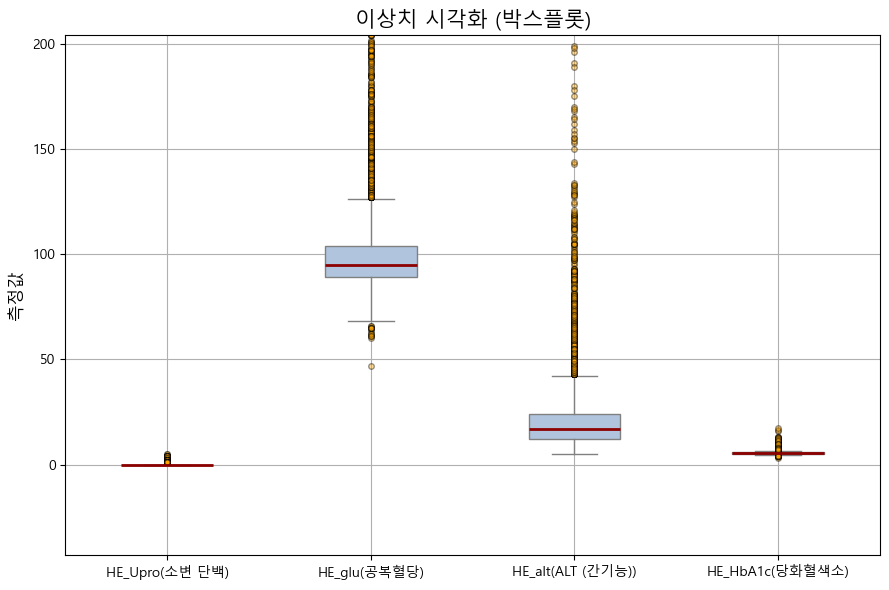

In [98]:
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows 사용자 기준, 필요시 주석 해제)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 시각화용 데이터 준비
columns_to_plot = ['HE_Upro', 'HE_glu', 'HE_alt', 'HE_HbA1c']
column_labels = {
    'HE_Upro': 'HE_Upro(소변 단백)',
    'HE_glu': 'HE_glu(공복혈당)',
    'HE_alt': 'HE_alt(ALT (간기능))',
    'HE_HbA1c' : 'HE_HbA1c(당화혈색소)'
}
data_boxplot = data[columns_to_plot].copy()
data_boxplot.columns = [column_labels[col] for col in columns_to_plot]

# 박스플롯
plt.figure(figsize=(9, 6))
box = data_boxplot.boxplot(
    grid=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightsteelblue', color='gray'),
    medianprops=dict(color='darkred', linewidth=2),
    flierprops=dict(marker='o', markerfacecolor='orange', markersize=4, alpha=0.4),
    whiskerprops=dict(color='gray'),
    capprops=dict(color='gray')
)

# 제목 및 라벨
plt.title('이상치 시각화 (박스플롯)', fontsize=15)
plt.ylabel('측정값', fontsize=12)

# Y축 상한 설정 (너무 높은 이상치가 시야 가리는 경우)
plt.ylim(top=data_boxplot.quantile(0.95).max() * 1.5)

plt.tight_layout()
plt.show()


1. **(공복혈당)**
👉 460 mg/dL은?  
실제 존재할 수는 있지만: 매우 드물고, 병원 입원 환자나 응급 상태에서 나타나는 수치입니다.  
일반 건강검진 데이터에서는 거의 보기 어려움 → 이상치 가능성 높음
- 250 ~ 350	고혈당 진행 중, 케톤산증 가능성↑	⚠️ 고위험
- 350 ~ 400	응급 고혈당 가능성 (증상 동반될 확률 높음)	⚠️ 응급 수준
- 400 이상	고삼투성 혼수(HHS) 또는 기기 오류 가능성	❗ 이상치 의심

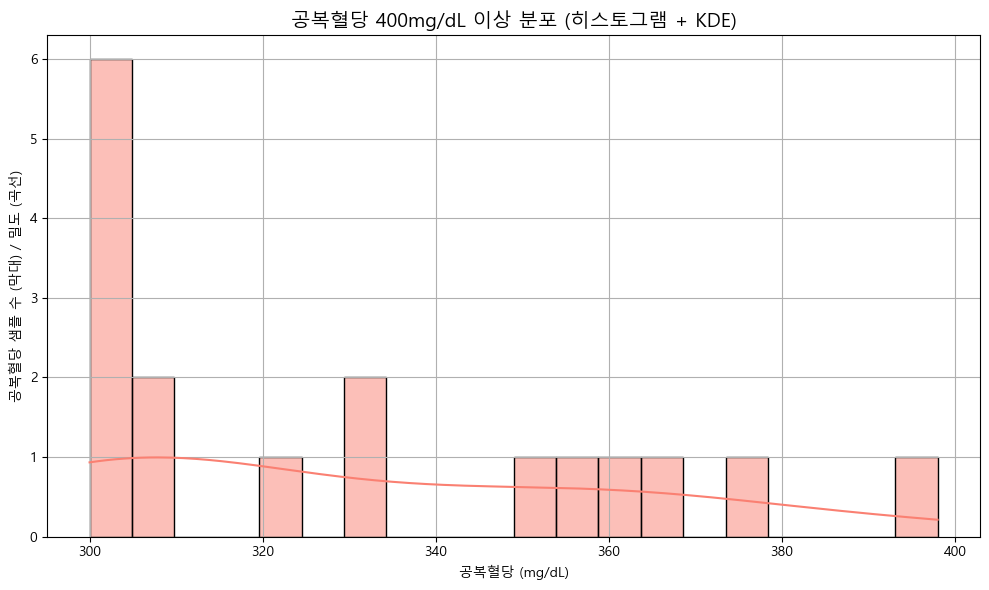

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# 공복혈당 400 이상 데이터만 추출
data_high_glu = data[data['HE_glu'] >= 300]

# 시각화
plt.figure(figsize=(10, 6))

sns.histplot(
    data=data_high_glu,
    x='HE_glu',
    bins=20,
    kde=True,  # ✅ KDE 곡선도 함께 그림
    color='salmon',
    edgecolor='black'
)

plt.title("공복혈당 400mg/dL 이상 분포 (히스토그램 + KDE)", fontsize=14)
plt.xlabel("공복혈당 (mg/dL)")
plt.ylabel("공복혈당 샘플 수 (막대) / 밀도 (곡선)")
plt.grid(True)
plt.tight_layout()
plt.show()


- 저혈당 (위험)	< 60	❗ 저혈당 증상 가능성 ↑
- 심각한 저혈당	< 50	❗ 실신·혼수 가능, 응급 수준
- 측정 오류 가능성	< 45	❓ 일반적 건강검진에선 드뭄, 이상치 의심

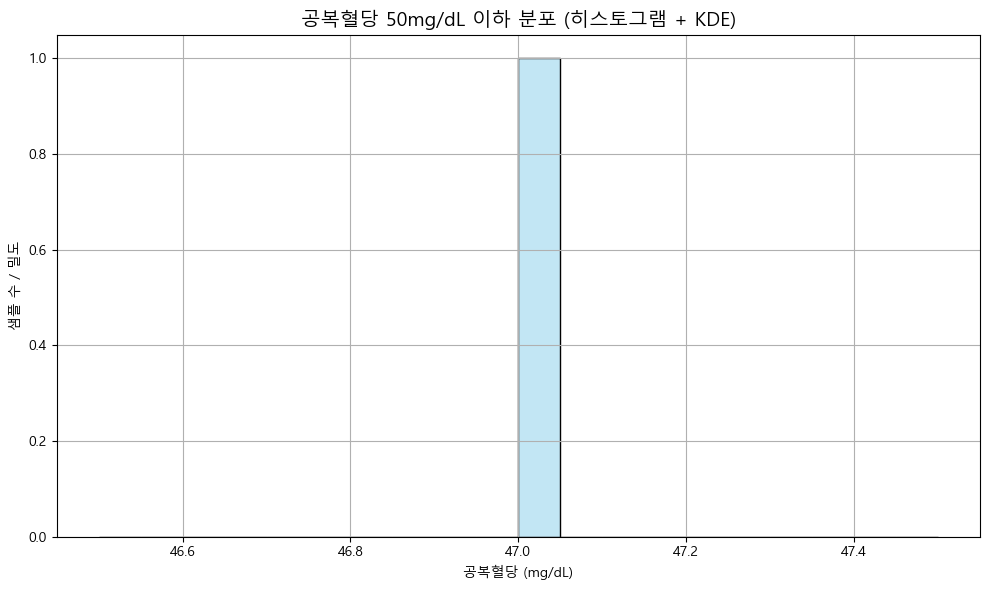

In [122]:
# 공복혈당 50 이하 데이터 추출
data_low_glu = data[data['HE_glu'] <= 50]

# 시각화
plt.figure(figsize=(10, 6))

sns.histplot(
    data=data_low_glu,
    x='HE_glu',
    bins=20,
    kde=True,
    color='skyblue',
    edgecolor='black'
)

plt.title("공복혈당 50mg/dL 이하 분포 (히스토그램 + KDE)", fontsize=14)
plt.xlabel("공복혈당 (mg/dL)")
plt.ylabel("샘플 수 / 밀도")
plt.grid(True)
plt.tight_layout()
plt.show()


**(간수치(ALT))의학적 절대 기준 초과**:

  - **2 이하**은 일반적인 외래 검사에서는 거의 나오지 않으며
  - **700 이상은 급성 상태 or 오류 가능성 간주**하는 연구도 많다.
- 중등도 상승	121 ~ 400	❗ 간질환 가능성 ↑
- 심한 상승	401 ~ 700	❗ 급성 간염, DILI, 간 괴사 의심
- 심각한 상승	700 ~ 1000+	⚠️ 응급 상황 or 기기 오류 가능성

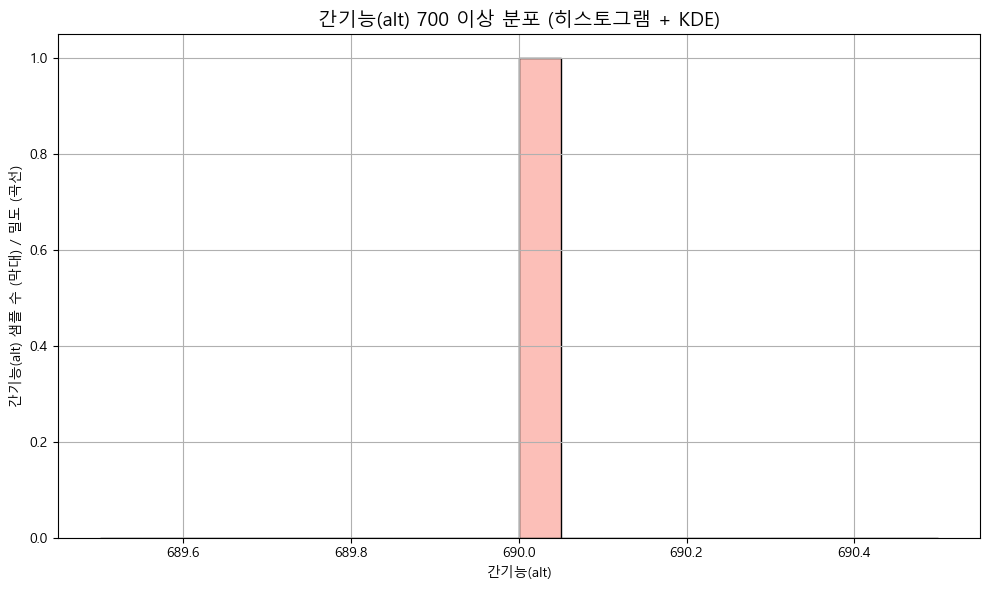

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

# 간기능(alt) 700 이상 데이터만 추출
data_high_glu = data[data['HE_alt'] >= 400]

# 시각화
plt.figure(figsize=(10, 6))

sns.histplot(
    data=data_high_glu,
    x='HE_alt',
    bins=20,
    kde=True,  # ✅ KDE 곡선도 함께 그림
    color='salmon',
    edgecolor='black'
)

plt.title("간기능(alt) 700 이상 분포 (히스토그램 + KDE)", fontsize=14)
plt.xlabel("간기능(alt)")
plt.ylabel("간기능(alt) 샘플 수 (막대) / 밀도 (곡선)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2012년~2023년/건강조사_2012~2023.csv")

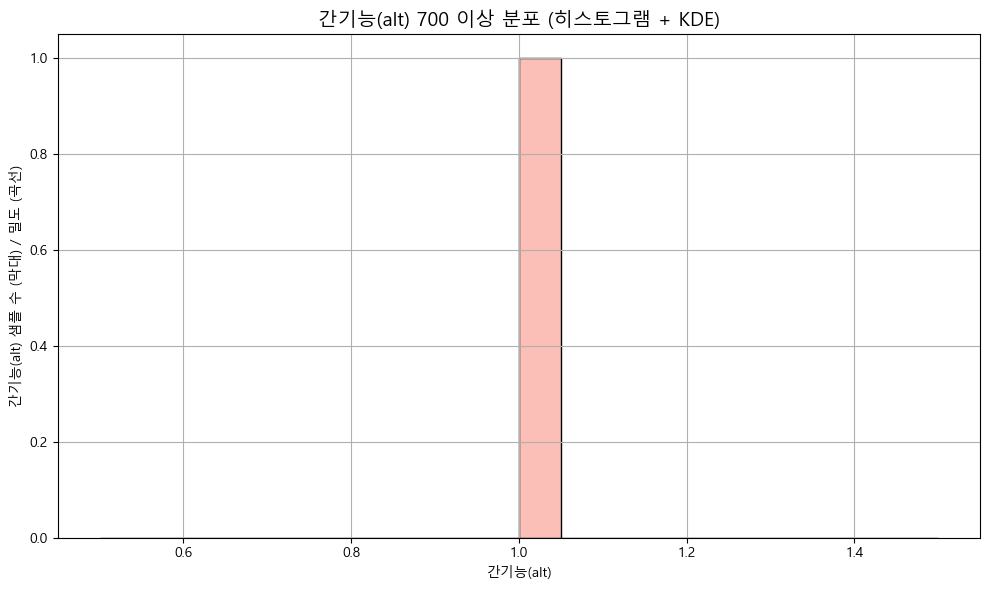

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 간기능(alt) 700 이상 데이터만 추출
data_high_glu = data[data['HE_alt'] <3]

# 시각화
plt.figure(figsize=(10, 6))

sns.histplot(
    data=data_high_glu,
    x='HE_alt',
    bins=20,
    kde=True,  # ✅ KDE 곡선도 함께 그림
    color='salmon',
    edgecolor='black'
)

plt.title("간기능(alt) 700 이상 분포 (히스토그램 + KDE)", fontsize=14)
plt.xlabel("간기능(alt)")
plt.ylabel("간기능(alt) 샘플 수 (막대) / 밀도 (곡선)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
set(sorted(data["HE_wt"]))

**- HE_DM_HbA1c(당뇨여부)의 이상치는 999,888 등 모름 이므로 이상치라 하면 안 됨**
**- HE_ht(신장), HE_wt(체중) 은 실제 값**

**타겟 변수 확인**

In [111]:
data['HE_HP'].value_counts()

HE_HP
1.0    4652
4.0    3631
3.0    1521
2.0     860
Name: count, dtype: int64

In [112]:
data['HE_obe'].value_counts()

HE_obe
2.0    3972
4.0    3120
3.0    2389
5.0     576
1.0     452
6.0     109
Name: count, dtype: int64

In [110]:
data['HE_DM_HbA1c'].value_counts()

HE_DM_HbA1c
1.0    5527
2.0    3367
3.0    1593
Name: count, dtype: int64

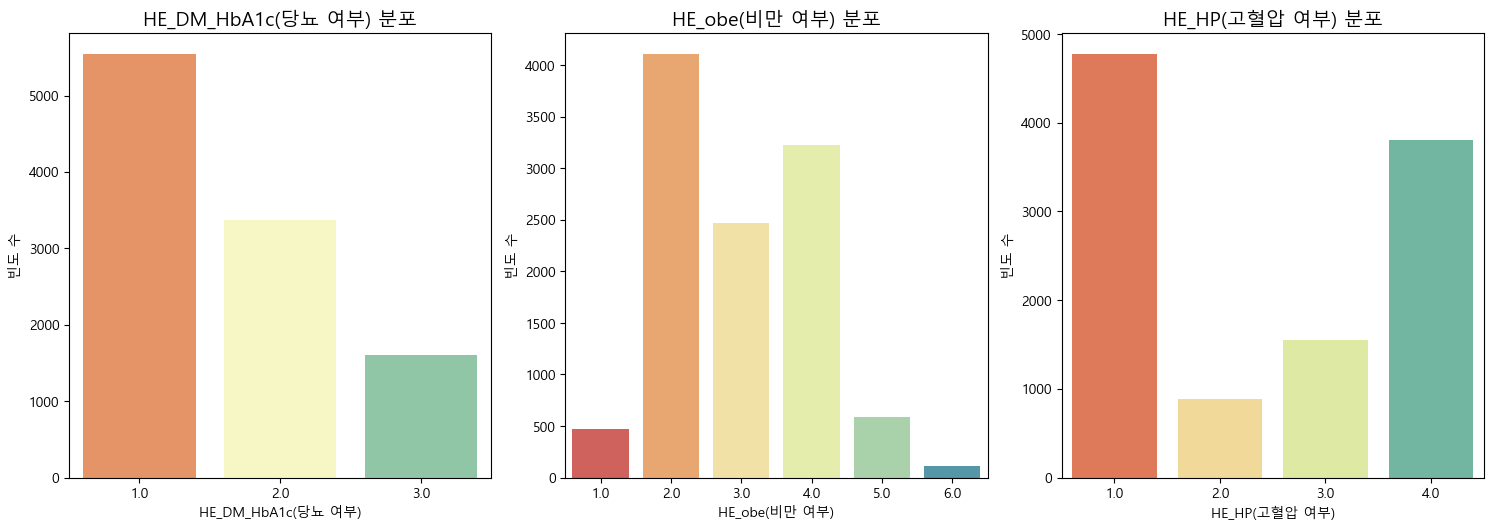

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': 'HE_DM_HbA1c(당뇨 여부)',
    'HE_obe': 'HE_obe(비만 여부)',
    'HE_HP': 'HE_HP(고혈압 여부)'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
#data = pd.read_csv("C:/건강검진/health_checkup/JDM/2012년~2023년/건강조사_2022_2023_통합.csv")

In [10]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2012년~2023년/건강데이터_2022_2023_합본.csv")

In [5]:
data

,ID,year,region,town_t,sex,age,incm,ho_incm,edu,occp,cfam,genertn,D_1_1,DI1_dg,DI1_ag,DI1_pr,DI1_pt,DI1_2,DI2_dg,DI2_ag,DI2_pr,DI2_pt,DI2_2,DE1_dg,DE1_ag,DE1_pr,DE1_pt,DE1_3,DE1_31,DE1_32,DE1_33,DE1_34,DE1_4,DN1_dg,DN1_ag,BH1,BO1,BO1_1,BO2_1,BD1,BD1_11,BD2_1,BP16_1,BP16_2,BP1,BP5,BS1_1,BS3_1,BS3_2,BS12_37,BS12_47,BS12_47_1,BS12_1,BS12_2,BE3_31,BE3_32,BE3_33,BE5_1,BE9,HE_fh,HE_HPfh1,HE_HPfh2,HE_HLfh1,HE_HLfh2,HE_DMfh1,HE_DMfh2,HE_sbp1,HE_dbp1,HE_sbp2,HE_dbp2,HE_HP,HE_ht,HE_wt,HE_wc,HE_BMI,HE_obe,HE_glu,HE_HbA1c,HE_DM_HbA1c,HE_chol,HE_HDL_st2,HE_TG,HE_LDL_drct,HE_HCHOL,HE_HTG,HE_ast,HE_alt,HE_BUN,HE_crea,HE_Upro,HE_Ucrea,HE_Ualb,L_BR_FQ,L_LN_FQ,L_DN_FQ,L_OUT_FQ,LS_VEG1,LS_FRUIT
0,YA01220302,2022.0,1.0,1.0,2.0,56.0,3.0,4.0,3.0,7.0,4.0,4.0,3.0,1.0,48.0,1.0,1.0,1.0,0.0,888.0,8.0,8.0,8.0,0.0,888.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,888.0,1.0,4.0,1.0,1.0,2.0,1.0,8.0,8.0,10.0,2.0,8.0,3.0,8.0,888.0,2.0,8.0,888.0,2.0,8.0,5.0,1.0,30.0,1.0,88.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,135.0,90.0,138.0,89.0,4.0,151.2,60.6,84.3,26.507517,4.0,94.0,5.6,1.0,199.0,56.0,181.0,122.0,0.0,0.0,22.0,16.0,13.0,0.61,0.0,84.6,9.7,3.0,1.0,1.0,5.0,2.0,2.0
1,YA01220303,2022.0,1.0,1.0,1.0,30.0,3.0,4.0,4.0,3.0,4.0,4.0,2.0,0.0,888.0,8.0,8.0,8.0,0.0,888.0,8.0,8.0,8.0,0.0,888.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,888.0,1.0,4.0,3.0,1.0,2.0,3.0,2.0,7.0,7.0,3.0,8.0,3.0,8.0,888.0,2.0,8.0,888.0,2.0,8.0,8.0,3.0,0.0,6.0,88.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,145.0,77.0,128.0,78.0,3.0,174.1,82.3,86.2,27.152029,4.0,84.0,5.3,1.0,122.0,48.0,63.0,63.0,0.0,0.0,28.0,18.0,14.0,0.86,0.0,54.3,NaN,1.0,1.0,1.0,4.0,2.0,3.0
2,YA01220304,2022.0,1.0,1.0,2.0,25.0,3.0,4.0,4.0,7.0,4.0,4.0,2.0,0.0,888.0,8.0,8.0,8.0,0.0,888.0,8.0,8.0,8.0,0.0,888.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,888.0,2.0,4.0,2.0,1.0,2.0,4.0,1.0,6.0,8.0,2.0,8.0,3.0,8.0,888.0,2.0,8.0,888.0,2.0,8.0,8.0,0.0,20.0,6.0,88.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,103.0,64.0,104.0,63.0,1.0,166.4,59.0,69.4,21.308131,2.0,87.0,5.0,1.0,202.0,75.0,53.0,124.0,0.0,NaN,17.0,15.0,8.0,0.60,0.0,192.4,9.4,4.0,1.0,2.0,3.0,2.0,2.0
3,YA01236501,2022.0,1.0,1.0,1.0,66.0,3.0,3.0,4.0,7.0,2.0,2.0,2.0,0.0,888.0,8.0,8.0,8.0,1.0,56.0,1.0,1.0,1.0,0.0,888.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,888.0,1.0,3.0,1.0,2.0,2.0,3.0,2.0,9.0,9.0,4.0,8.0,2.0,3.0,888.0,2.0,8.0,888.0,2.0,8.0,8.0,1.0,30.0,1.0,88.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,116.0,80.0,120.0,78.0,2.0,168.7,67.1,83.5,23.577207,3.0,87.0,5.2,1.0,136.0,47.0,123.0,74.0,1.0,0.0,20.0,15.0,18.0,0.90,0.0,99.1,NaN,1.0,1.0,1.0,4.0,1.0,2.0
4,YA01236502,2022.0,1.0,1.0,2.0,62.0,3.0,3.0,3.0,6.0,2.0,2.0,2.0,0.0,888.0,8.0,8.0,8.0,1.0,53.0,1.0,1.0,1.0,0.0,888.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,888.0,1.0,3.0,1.0,1.0,2.0,2.0,1.0,7.0,9.0,3.0,8.0,3.0,8.0,888.0,2.0,8.0,888.0,2.0,8.0,8.0,1.0,0.0,4.0,88.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,145.0,89.0,131.0,87.0,3.0,157.1,53.9,77.5,21.839183,2.0,91.0,5.6,1.0,149.0,53.0,110.0,82.0,1.0,0.0,26.0,23.0,10.0,0.67,0.0,46.5,3.3,1.0,1.0,1.0,6.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13189,YR62368101,2023.0,8.0,2.0,1.0,80.0,2.0,1.0,1.0,7.0,2.0,2.0,5.0,1.0,70.0,1.0,1.0,1.0,0.0,888.0,8.0,8.0,8.0,1.0,73.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,888.0,2.0,2.0,2.0,2.0,2.0,3.0,1.0,4.0,5.0,3.0,2.0,2.0,3.0,888.0,2.0,8.0,888.0,2.0,8.0,1.0,88.0,88.0,1.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,68.0,119.0,68.0,4.0,162.4,63.3,97.0,24.001128,3.0,101.0,5.3,3.0,193.0,38.0,188.0,124.0,0.0,0.0,18.0,12.0,18.0,1.44,0.0,48.3,9.1,1.0,1.0,1.0,5.0,1.0,5.0
13190,YR62368102,2023.0,8.0,2.0,2.0,78.0,2.0,1.0,1.0,7.0,2.0,2.0,3.0,1.0,76.0,1.0,1.0,1.0,0.0,888.0,8.0,8.0,8.0,0.0,888.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,888.0,1.0,5.0,1.0,4.0,2.0,2.0,1.0,4.0,5.0,3.0,2.0,3.0,8.0,888.0,2.0,8.0,888.0,

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# 컬럼명 매핑 사전 (형님이 주신 그대로 사용)
column_mapping = {
    'ID': 'ID',
    'year': 'year(조사연도)',
    'age': 'age(연령)',
    'sex': 'sex(성별)',
    'HE_ht': 'HE_ht(신장(cm))',
    'HE_wt': 'HE_wt(체중(kg))',
    'HE_wc': 'HE_wc(허리둘레(cm))',
    'HE_BMI': 'HE_BMI(체질량지수)',
    'HE_sbp1': 'HE_sbp1(수축기 혈압)',
    'HE_dbp1': 'HE_dbp1(이완기 혈압)',
    'HE_Upro': 'HE_Upro(소변 단백)',
    'HE_glu': 'HE_glu(공복혈당)',
    'HE_HbA1c': 'HE_HbA1c(당화혈색소)',
    'HE_chol': 'HE_chol(총 콜레스테롤)',
    'HE_HDL_st2': 'HE_HDL_st2(HDL 콜레스테롤)',
    'HE_TG': 'HE_TG(중성지방)',
    'HE_LDL_drct': 'HE_LDL_drct(LDL 콜레스테롤)',
    'HE_crea': 'HE_crea(크레아티닌)',
    'HE_ast': 'HE_ast(AST (간기능))',
    'HE_alt': 'HE_alt(ALT (간기능))',
    'HE_obe': 'HE_obe(비만 여부)',
    'HE_HP': 'HE_HP(고혈압 여부)',
    'DI1_dg': 'DI1_dg(고혈압 의사진단 여부)',
    'HE_DM_HbA1c': 'HE_DM_HbA1c(당뇨 여부 (HbA1c))',
    'DE1_dg': 'DE1_dg(당뇨병 의사진단 여부)',
    'DE1_pt': 'DE1_pt(당뇨병치료여부)',
    'DI1_pt': 'DI1_pt(고혈압치료여부)'
}

# ⏺ 매핑된 컬럼만 추출
mapped_columns = list(column_mapping.keys())
data_mapped = data[mapped_columns]

# ⏺ 결측치 정보 계산
missing_df = pd.DataFrame({
    '결측치 개수': data_mapped.isnull().sum(),
    '결측 비율(%)': data_mapped.isnull().mean() * 100
})

# ⏺ 결측치가 있는 컬럼만 필터링
missing_df = missing_df[missing_df['결측치 개수'] > 0]

# ⏺ 한글 컬럼명으로 매핑
missing_df.index = missing_df.index.map(column_mapping)

# ⏺ 정렬
missing_df = missing_df.sort_values(by='결측 비율(%)', ascending=False)

# ⏺ 전체 출력
pd.set_option('display.max_rows', None)
print(missing_df)


                            결측치 개수   결측 비율(%)
HE_LDL_drct(LDL 콜레스테롤)       65639  72.108582
HE_DM_HbA1c(당뇨 여부 (HbA1c))   63644  69.916949
ID                           31006  34.062047
HE_HP(고혈압 여부)                22722  24.961550
HE_obe(비만 여부)                21118  23.199455
HE_Upro(소변 단백)               17141  18.830470
HE_HbA1c(당화혈색소)              17022  18.699741
HE_alt(ALT (간기능))            16861  18.522872
HE_glu(공복혈당)                 16847  18.507492
HE_HDL_st2(HDL 콜레스테롤)        16839  18.498704
HE_ast(AST (간기능))            16828  18.486620
HE_crea(크레아티닌)               16827  18.485521
HE_chol(총 콜레스테롤)             16827  18.485521
HE_TG(중성지방)                  16827  18.485521
HE_dbp1(이완기 혈압)              12185  13.385991
HE_sbp1(수축기 혈압)              12185  13.385991
HE_wc(허리둘레(cm))               5903   6.484818
DI1_dg(고혈압 의사진단 여부)           4768   5.237949
DE1_pt(당뇨병치료여부)               4768   5.237949
DE1_dg(당뇨병 의사진단 여부)           4768   5.237949
DI1_pt(고혈압치료여부)               4768

전처리

- **이상치 처리**  
공복혈당 400이상  
간수치 2이하, 700이상

In [11]:
# 공복혈당: 50 이상 & 350 이하
data = data[(data['HE_glu'] >= 50) & (data['HE_glu'] <= 350)]

# ALT (간수치): 400 미만
data = data[data['HE_alt'] < 400]

In [127]:
data.describe()

,year,region,town_t,apt_t,sex,age,age_month,incm,ho_incm,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_oe,wt_bia,wt_ntr,wt_tot,wt_oent,wt_biant,kstrata,cfam,genertn,allownc,house,live_t,ainc_unit1,ainc_1,ainc,marri_1,marri_2,fam_rela,tins,npins,D_1_1,D_2_1,D_2_wk,DI1_dg,DI1_ag,DI1_pr,DI1_pt,DI1_2,DI2_dg,DI2_ag,DI2_pr,DI2_pt,DI2_2,DE1_dg,DE1_ag,DE1_pr,DE1_pt,DE1_3,DE1_31,DE1_32,DE1_33,DE1_34,DE1_35,DE1_4,DJ4_dg,DJ4_ag,DJ4_3,DL1_dg,DL1_ag,DJ8_dg,DJ8_ag,DJ6_dg,DJ6_ag,DH4_dg,DH4_ag,DN1_dg,DN1_ag,BP17_dg,BH9_11,BH1,BH2_61,AC1_yr,AC3,AC3_1_01,AC3_1_02,AC3_1_03,AC3_2_01,AC3_2_02,AC3_2_03,AC8_1_01,AC8_1_02,AC8_1_03,AC8_1e_01,AC8_1e_02,AC8_1e_03,AC8_2w_01,AC8_2w_02,AC8_2w_03,AC8_2_01,AC8_2_02,AC8_2_03,AC8_3w_01,AC8_3w_02,AC8_3w_03,AC8_3_01,AC8_3_02,AC8_3_03,ij_expr,educ,graduat,EC_pedu_1,EC_pedu_2,CH2_1,CH2_2,EC1_1,EC_occp,EC_stt_1,EC_stt_2,EC_wht_0,EC_wht_23,EC_lgw_2,EC_lgw_4,EC_lgw_5,BO1,BO1_1,BO1_2,BO1_3,BO2_1,BO3_01,BO3_02,BO3_03,BO3_14,BO3_05,BO3_04,BO3_12,BO3_07,BO3_09,BO3_10,BD1,BD2,BD1_11,BD2_1,BD2_14,BD2_31,BD2_32,BD7_4,BD7_5,BD7_61,BD7_62,BD7_63,BD7_64,BD7_65,BD7_66,dr_month,BA2_12,BA2_13,BA2_14,BA2_2_1,BA2_2_2,BA2_2_3,BA2_2_4,BA2_2_5,BA2_2_6,BA2_22,BA1_1,BA1_3,BA1_2,sc_seatblt,sc_seatblt2,sc_seatblt3,BP16_1,BP16_2,BP17_2,BP17_3,BP17_4,BP_PHQ_1,BP_PHQ_2,BP_PHQ_3,BP_PHQ_4,BP_PHQ_5,BP_PHQ_6,BP_PHQ_7,BP_PHQ_8,BP_PHQ_9,mh_PHQ_S,BP_GAD_1,BP_GAD_2,BP_GAD_3,BP_GAD_4,BP_GAD_5,BP_GAD_6,BP_GAD_7,mh_GAD_S,BP1,BP5,BP6_10,BP6_2,BP6_31,BP7,mh_stress,BS1_1,BS2_1,BS3_1,BS3_2,BS3_3,BS6_2,BS6_2_1,BS6_2_2,BS6_3,BS6_4,BS6_4_1,BS6_4_2,BS12_37,BS12_47,BS12_47_1,BS12_47_2,BS12_1,BS12_2,BS12_31,BS12_32,BS12_33,BS12_34,BS12_36,BS12_41,BS12_42,BS12_43,BS12_44,BS12_46,BS5_4,BS5,BS5_1,BS5_21,BS5_28,BS5_26,BS5_33,BS5_34,BS5_32,BS5_29,BS5_30,BS8_2,BS9_2,BS13,BS10_1,BS2,BS10_2,BS10_3,sm_presnt,BE3_71,BE3_72,BE3_73,BE3_74,BE3_81,BE3_82,BE3_83,BE3_84,BE3_91,BE3_92,BE3_93,BE3_94,BE3_75,BE3_76,BE3_77,BE3_78,BE3_85,BE3_86,BE3_87,BE3_88,BE8_1,BE8_2,BE3_31,BE3_32,BE3_33,BE5_1,BE9,pa_aerobic,LW_ms,LW_mp_a,LW_ms_a,LW_pr,LW_pr_1,LW_mt,LW_mt_a1,LW_mt_a2,LW_br,LW_br_ch,LW_br_dur,LW_br_yy,LW_br_mm,LW_oc,HE_fst,HE_mens,HE_prg,HE_dprg,HE_fh,HE_HPfh1,HE_HPfh2,HE_HPfh3,HE_HLfh1,HE_HLfh2,HE_HLfh3,HE_IHDfh1,HE_IHDfh2,HE_IHDfh3,HE_STRfh1,HE_STRfh2,HE_STRfh3,HE_DMfh1,HE_DMfh2,HE_DMfh3,HE_rPLS,HE_PLS_30,HE_mPLS,HE_nARM,HE_sbp1,HE_dbp1,HE_sbp2,HE_dbp2,HE_sbp3,HE_dbp3,HE_sbp,HE_dbp,HE_HP,HE_ht,HE_wt,HE_wc,HE_nc,HE_BMI,HE_obe,HE_wt_pct,HE_BMI_pct,HE_glu,HE_HbA1c,HE_DM_HbA1c,HE_chol,HE_HDL_st2,HE_TG,HE_LDL_drct,HE_HCHOL,HE_HTG,HE_ast,HE_alt,HE_hepaB,HE_hepaC,HE_HB,HE_HCT,HE_anem,HE_BUN,HE_crea,HE_WBC,HE_RBC,HE_Bplt,HE_Uacid,HE_hsCRP,HE_D2,HE_D3,HE_D3_3epi,HE_Uph,HE_Unitr,HE_Usg,HE_Upro,HE_Uglu,HE_Uket,HE_Ubil,HE_Ubld,HE_Uro,HE_Ucrea,HE_UNa,HE_Ualb,HE_Ukal,O_TC,O_PROS_U,O_PROS_L,O_IMP_UI,O_IMP_UM,O_IMP_LI,O_IMP_LM,O_BR_N_U,O_BR_N_L,O_DENT_U,O_DENT_L,O_F,OR1,O_pain,O_ortho,BM1_0,BM1_1,BM1_2,BM1_3,BM1_4,BM1_5,BM1_6,BM1_7,BM1_8,BM2_1,BM2_3,BM2_2,BM2_4,BM2_5,BM13,BM13_1,BM13_2,BM13_3,BM13_4,BM13_5,BM7,O_chew_d,BM8,OR1_2,MO4_00,MO4_4,MO4_9,MO4_7,MO4_8,MO4_17_1,MO4_17_2,MO4_11,MO4_12,MO4_18,MO4_15,BM14,BM14_1,GS_use,GS_mea_r_1,GS_mea_r_2,GS_mea_l_1,GS_mea_l_2,BIA_ex,BIA_FFM,BIA_LRA,BIA_LLA,BIA_LRL,BIA_LLL,BIA_BFM,BIA_PBF,BIA_FRA,BIA_FLA,BIA_FT,BIA_FRL,BIA_FLL,BIA_TBW,BIA_ICW,BIA_ECW,BIA_WBPA50,T_ex,T_Q_HR,T_Q_HR_1,T_Q_HR_2,T_NQ_OCP,T_NQ_PH2,T_NQ_PH2_T,T_Q_VN,T_Q_VN_1,T_Q_VN_2,T_Q_DZ,T_Q_DZ2,T_Q_DZ3,T_Q_DZ4,T_Q_DZ5,T_Q_DZ6,T_Q_DZ7,T_Q_CR,T_Q_CR1,T_Q_CR2,T_Q_CR3,T_Q_CR4,T_Q_ALLE,T_Q_SNST1,T_Q_SNST2,T_Q_SNST3,T_Q_SNST4,T_Q_SINU,T_Q_SINU_1,T_Q_VC,T_Q_VC1,T_HR_EX_R,T_HR_EX_R_1,T_HR_EX_L,T_HR_EX_L_1,T_HR500_pass,T_HR1000_pass,T_HR2000_pass,T_HR4000_pass,T_HR500_RT,T_HR1000_RT,T_HR2000_RT,T_HR4000_RT,T_HR8000_RT,T_HR500_LT,T_HR1000_LT,T_HR2000_LT,T_HR4000_LT,T_HR8000_LT,T_HL_mod,T_HL_mild,T_IM_EX_R,T_IM_EX_R_1,T_IM_EX_L,T_IM_EX_L_1,T_IM_A_R,T_IM_A_L,T_IM_B_R,T_IM_B_L,T_IM_C_R,T_IM_C_L,T_IM_FL_R,T_IM_FL_L,T_Tymp_Dis,E_ex,E_Q_EX,E_RT,E_CT,E_EXC_1,E_Cr_m,E_Cr_1,E_Cl_m,E_Cl_1,E_Dr_dsph,E_Dr_dcyl,E_Dr_a,

**이상치 처리 후 MAX, MIN 값 비교

In [ ]:
# column_mapping = {
#     'HE_glu': 'HE_glu(공복혈당)',
#     'HE_alt': 'HE_alt(AlT (간기능))'
# }

# # 1. 영어 컬럼 순서 (원하는 순서)
# original_columns = [
#     'HE_glu', 'HE_alt', 
# ]

# # 2. 한글 매핑된 컬럼 리스트 만들기
# kor_columns = [column_mapping[col] for col in original_columns]

# # 3. 컬럼명 한글로 바꾸기
# data = data.rename(columns=column_mapping)

# # 4. 원하는 순서로 재정렬
# data = data[kor_columns]

# # 3️⃣ EDA 요약 
# eda = pd.DataFrame(index=data.columns)
# eda['고유값 개수'] = data.nunique()
# eda['최소값'] = data.min(numeric_only=True)
# eda['최대값'] = data.max(numeric_only=True)

# # 간수치 및 공복혈당 컬럼만 필터링
# eda_selected = eda.loc[
#     ['HE_glu(공복혈당)', 'HE_alt(AlT (간기능))']
# ]

# eda_selected


,고유값 개수,최소값,최대값
HE_glu(공복혈당),198,60.0,334.0
HE_alt(AlT (간기능)),156,5.0,359.0


- **결측치 처리**

In [12]:
import pandas as pd

# 남기고 싶은 컬럼 리스트
columns_to_keep = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu','HE_HbA1c', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    'HE_obe', 'HE_HP', 'HE_DM_HbA1c',
    'DE1_dg', 'DI1_dg'
]

# 원래 데이터프레임이 df일 때
data = data[columns_to_keep]


In [13]:
# HE_DM_HbA1c
if 'HE_DM_HbA1c' in data.columns:
    data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DE1_dg' in data.columns:
        print(f"DE1_dg missing ratio: {data['DE1_dg'].isnull().mean()}")
        data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].fillna(data['DE1_dg'].map({0: 1, 1: 3}))
    # 남은 결측치는 드랍랍
    if data['HE_DM_HbA1c'].isnull().any():
        data = data[data['HE_DM_HbA1c'].notnull()]
    print(f"HE_DM_HbA1c NaN count after: {data['HE_DM_HbA1c'].isnull().sum()}")

# HE_obe
if 'HE_obe' in data.columns:
    data['HE_obe'] = data['HE_obe'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'HE_BMI' in data.columns:
        # BMI가 KNN 대체된 경우 표시
        data['HE_BMI_imputed'] = data['HE_BMI'].isnull().astype(int)
        data['HE_obe'] = data.apply(
            lambda row: row['HE_obe'] if pd.notna(row['HE_obe']) else (
                1 if row['HE_BMI'] < 18.5 else
                2 if row['HE_BMI'] < 25 else
                3 if row['HE_BMI'] < 30 else
                4 if row['HE_BMI'] < 35 else
                5 if row['HE_BMI'] < 40 else
                6
            ),
            axis=1
        )
    # 남은 결측치는 드랍랍
    if data['HE_obe'].isnull().any():
        data = data[data['HE_obe'].notnull()]
    print(f"HE_obe NaN count after: {data['HE_obe'].isnull().sum()}")

# HE_HP
if 'HE_HP' in data.columns:
    data['HE_HP'] = data['HE_HP'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DI1_dg' in data.columns:
        print(f"DI1_dg missing ratio: {data['DI1_dg'].isnull().mean()}")
        data['HE_HP'] = data['HE_HP'].fillna(data['DI1_dg'].map({0: 1, 1: 4}))
    # 남은 결측치는 드랍랍
    if data['HE_HP'].isnull().any():
        data = data[data['HE_HP'].notnull()]
    print(f"HE_HP NaN count after: {data['HE_HP'].isnull().sum()}")


#결측치 비율 낮은 변수 처리
# low_missing_columns = [
#     'DI1_dg', 
#     'DE1_dg', 
# ]
continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI', 'HE_HbA1c'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data

# knn_scaler_filename = 'HE_DM_HbA1c_knn_scaler.pkl'
# knn_imputer_filename = 'HE_DM_HbA1c_knn_imputer.pkl'
# joblib.dump(knn_data_scaled, knn_scaler_filename)
# joblib.dump(imputer_knn, knn_imputer_filename)
# knn_scaler_filename = 'HE_obe_knn_scaler.pkl'
# knn_imputer_filename = 'HE_obe_knn_imputer.pkl'
# joblib.dump(knn_data_scaled, knn_scaler_filename)
# joblib.dump(imputer_knn, knn_imputer_filename)
# knn_scaler_filename = 'HE_HP_knn_scaler.pkl'
# knn_imputer_filename = 'HE_HP_knn_imputer.pkl'
# joblib.dump(knn_data_scaled, knn_scaler_filename)
# joblib.dump(imputer_knn, knn_imputer_filename)

print("결측치 처리 후 데이터 상태:")
print(data.isnull().sum())
print("\n타겟 변수 클래스 비율:")
for target in ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']:
    if target in data.columns:
        print(f"\n{target}:\n{data[target].value_counts(normalize=True)}")
print("\n기본 통계량:")
print(data.describe())

# 전처리 코드 끝에 추가
#data.to_csv('건강조사_2022~2023_통합(가공된).csv', index=False, encoding='utf-8-sig')

DE1_dg missing ratio: 8.541168431841476e-05
HE_DM_HbA1c NaN count after: 0
HE_obe NaN count after: 0
DI1_dg missing ratio: 0.0
HE_HP NaN count after: 0
Median for HE_wt: 62.8
Median for HE_ht: 163.0
Median for HE_BMI: 23.74976543441547
결측치 처리 후 데이터 상태:
ID                0
year              0
age               0
sex               0
HE_ht             0
HE_wt             0
HE_wc             0
HE_BMI            0
HE_sbp1           0
HE_dbp1           0
HE_Upro           0
HE_glu            0
HE_HbA1c          0
HE_chol           0
HE_HDL_st2        0
HE_TG             0
HE_LDL_drct       0
HE_crea           0
HE_ast            0
HE_alt            0
HE_obe            0
HE_HP             0
HE_DM_HbA1c       0
DE1_dg            0
DI1_dg            0
HE_BMI_imputed    0
dtype: int64

타겟 변수 클래스 비율:

HE_DM_HbA1c:
HE_DM_HbA1c
1.0    0.538042
2.0    0.310803
3.0    0.151154
Name: proportion, dtype: float64

HE_obe:
HE_obe
2.0    0.368052
4.0    0.288089
3.0    0.221422
5.0    0.053093
1.0    0.041

In [202]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2012년~2023년/건강조사_2022~2023_통합(가공된).csv")

In [188]:
print(data.columns.tolist())

['ID', 'year', 'age', 'sex', 'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI', 'HE_sbp1', 'HE_dbp1', 'HE_Upro', 'HE_glu', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_obe', 'HE_HP', 'HE_DM_HbA1c', 'DE1_dg', 'DI1_dg', 'HE_BMI_imputed']


**독립변수간 상관관계**

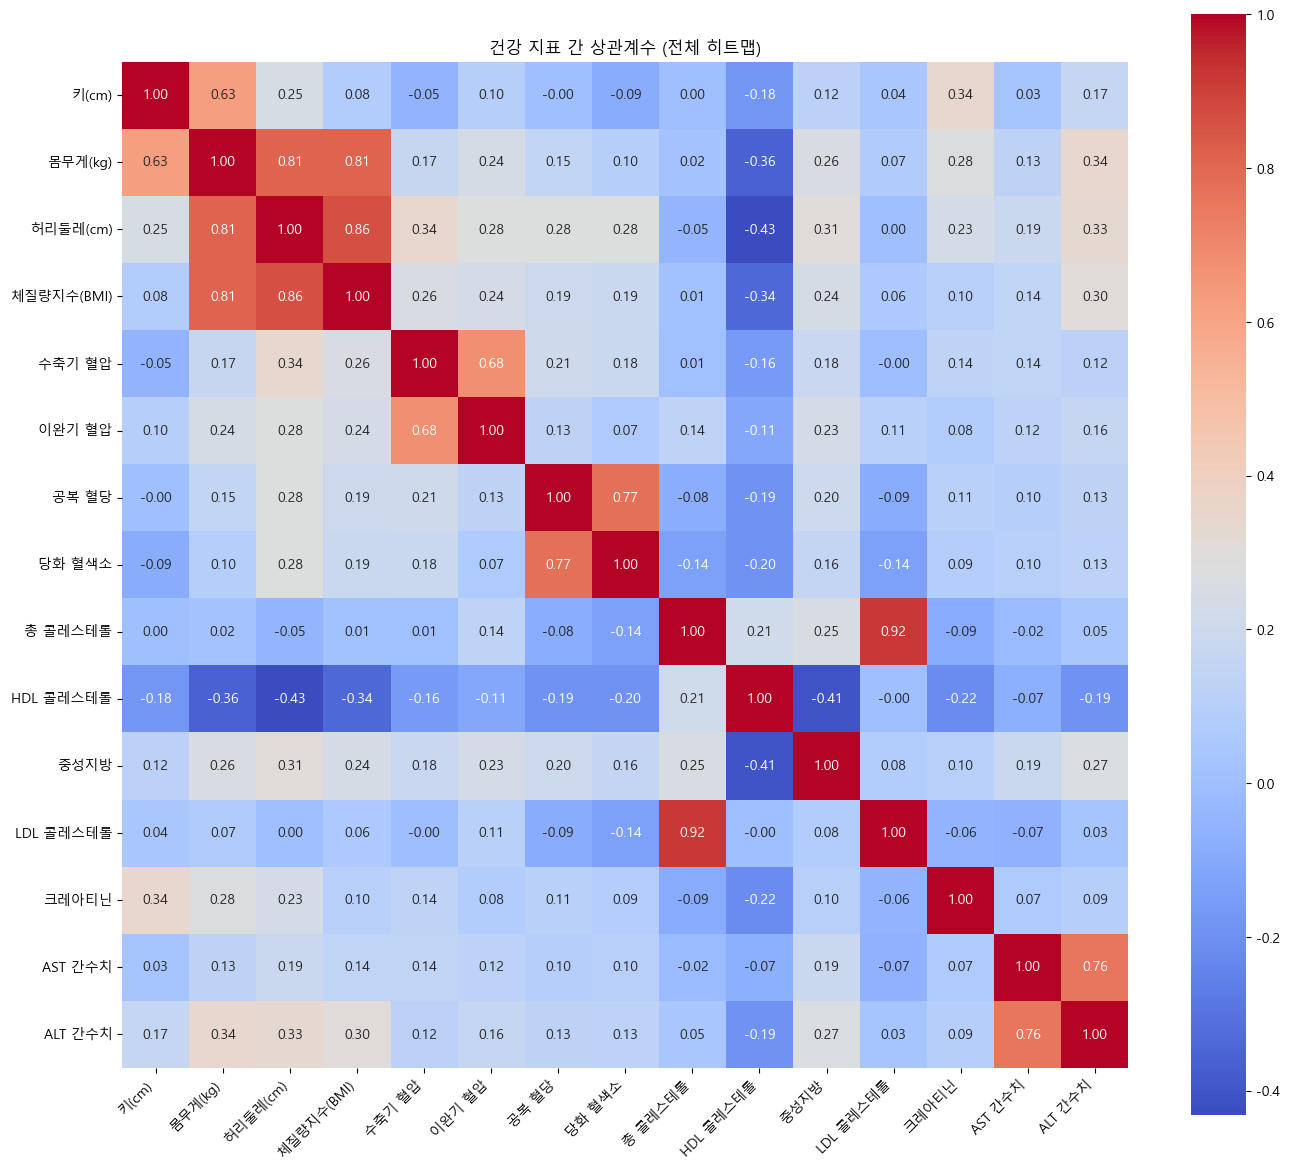

📌 <양의 상관관계>
총 콜레스테롤 ↔ LDL 콜레스테롤 : 0.92 
허리둘레(cm) ↔ 체질량지수(BMI) : 0.86 
몸무게(kg) ↔ 허리둘레(cm) : 0.81 
몸무게(kg) ↔ 체질량지수(BMI) : 0.81 
공복 혈당 ↔ 당화 혈색소 : 0.77 
AST 간수치 ↔ ALT 간수치 : 0.76 
수축기 혈압 ↔ 이완기 혈압 : 0.68 
키(cm) ↔ 몸무게(kg) : 0.63 
키(cm) ↔ 크레아티닌 : 0.34 
허리둘레(cm) ↔ 수축기 혈압 : 0.34 
몸무게(kg) ↔ ALT 간수치 : 0.34 
허리둘레(cm) ↔ ALT 간수치 : 0.33 
허리둘레(cm) ↔ 중성지방 : 0.31 
체질량지수(BMI) ↔ ALT 간수치 : 0.30 

📌 <음의 상관관계>
허리둘레(cm) ↔ HDL 콜레스테롤 : -0.43 
HDL 콜레스테롤 ↔ 중성지방 : -0.41 
몸무게(kg) ↔ HDL 콜레스테롤 : -0.36 
체질량지수(BMI) ↔ HDL 콜레스테롤 : -0.34 


In [189]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 컬럼명 한글 맵
column_name_map = {
    'HE_ht': '키(cm)',
    'HE_wt': '몸무게(kg)',
    'HE_wc': '허리둘레(cm)',
    'HE_BMI': '체질량지수(BMI)',
    'HE_sbp1': '수축기 혈압',
    'HE_dbp1': '이완기 혈압',
    'HE_glu': '공복 혈당',
    'HE_HbA1c' : '당화 혈색소',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤',
    'HE_TG': '중성지방',
    'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌',
    'HE_ast': 'AST 간수치',
    'HE_alt': 'ALT 간수치'
}

# 분석 대상 변수
selected_columns = list(column_name_map.keys())
correlation_matrix = data[selected_columns].corr()

# 한글 컬럼명 적용
corr_named = correlation_matrix.rename(columns=column_name_map, index=column_name_map)

# 히트맵 전체 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(corr_named, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("건강 지표 간 상관계수 (전체 히트맵)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 유의미한 상관계수 추출
threshold = 0.3
positive_corrs = []
negative_corrs = []

for i in range(len(corr_named.columns)):
    for j in range(i + 1, len(corr_named.columns)):
        corr_value = corr_named.iloc[i, j]
        if corr_value >= threshold:
            positive_corrs.append((corr_named.index[i], corr_named.columns[j], corr_value))
        elif corr_value <= -threshold:
            negative_corrs.append((corr_named.index[i], corr_named.columns[j], corr_value))

# 정렬 (절댓값 기준 내림차순)
positive_corrs.sort(key=lambda x: abs(x[2]), reverse=True)
negative_corrs.sort(key=lambda x: abs(x[2]), reverse=True)

# 결과 출력
print("📌 <양의 상관관계>")
for var1, var2, corr in positive_corrs:
    print(f"{var1} ↔ {var2} : {corr:.2f} ")

print("\n📌 <음의 상관관계>")
for var1, var2, corr in negative_corrs:
    print(f"{var1} ↔ {var2} : {corr:.2f} ")



**타겟변수와 독립변수의 상관관계 확인**

In [135]:
!pip install pingouin

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 8.2 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


**상관계수 파악 후 내린 가설** : 기존 데이터셋에는 고혈압 또는 당뇨병인데 고혈압 또는 당뇨를 치료한 사람의 수치가 껴있어 변수들간에 상관계수를 방해한다.  
**맨 위로가서 가설검증 확인**

**나이그룹 별 질병유병률 확인**

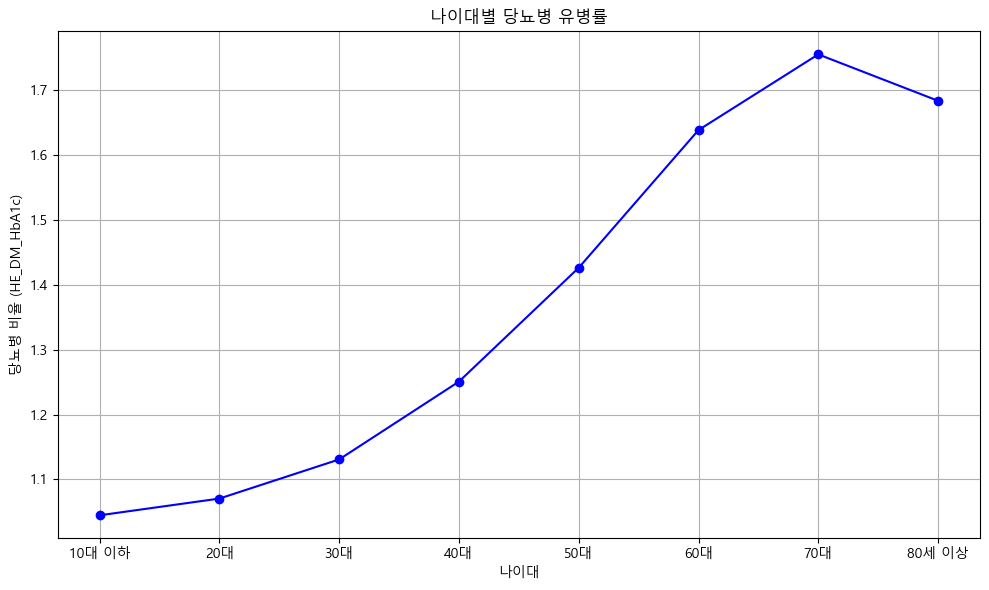

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 나이 그룹 생성 (AGE_GROUP 컬럼 추가)
bins = [0, 19, 29, 39, 49, 59, 69, 79, 120]  # 80세 이상 포함
labels = ['10대 이하', '20대', '30대', '40대', '50대', '60대', '70대', '80세 이상']

data['AGE_GROUP'] = pd.cut(data['age'], bins=bins, labels=labels, right=True)

# 2. 나이그룹별 당뇨병 평균값(= 유병률) 계산
group_stats = data.groupby('AGE_GROUP')['HE_DM_HbA1c'].mean().reset_index()

# 3. 시각화
plt.figure(figsize=(10, 6))
plt.plot(group_stats['AGE_GROUP'], group_stats['HE_DM_HbA1c'], marker='o', color='blue')
plt.xlabel('나이대')
plt.ylabel('당뇨병 비율 (HE_DM_HbA1c)')
plt.title('나이대별 당뇨병 유병률')
plt.grid(True)
plt.tight_layout()
plt.show()

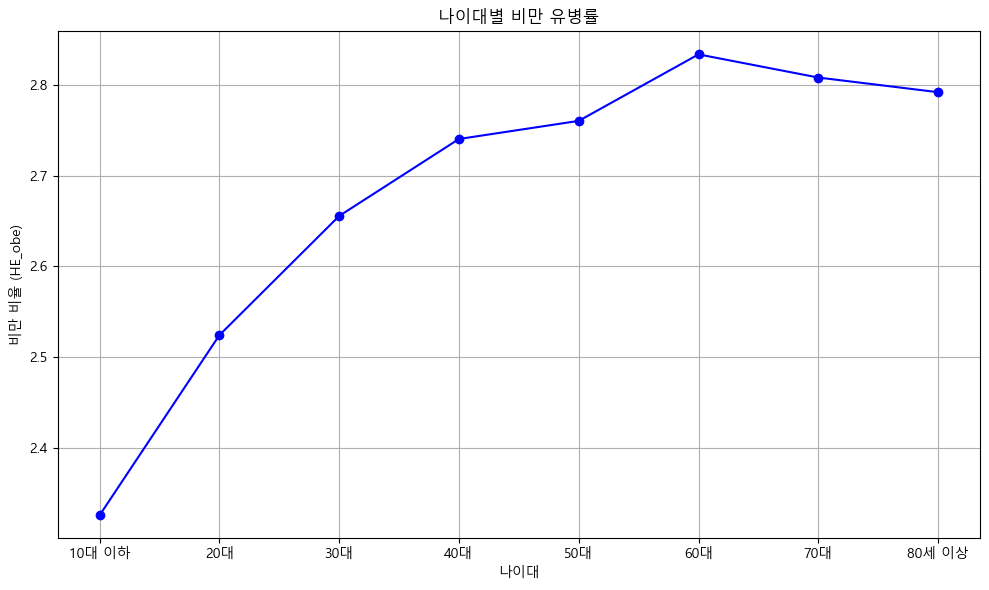

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 나이 그룹 생성 (AGE_GROUP 컬럼 추가)
bins = [0, 19, 29, 39, 49, 59, 69, 79, 120]  # 80세 이상 포함
labels = ['10대 이하', '20대', '30대', '40대', '50대', '60대', '70대', '80세 이상']

data['AGE_GROUP'] = pd.cut(data['age'], bins=bins, labels=labels, right=True)

# 2. 나이그룹별 당뇨병 평균값(= 유병률) 계산
group_stats = data.groupby('AGE_GROUP')['HE_obe'].mean().reset_index()

# 3. 시각화
plt.figure(figsize=(10, 6))
plt.plot(group_stats['AGE_GROUP'], group_stats['HE_obe'], marker='o', color='blue')
plt.xlabel('나이대')
plt.ylabel('비만 비율 (HE_obe)')
plt.title('나이대별 비만 유병률')
plt.grid(True)
plt.tight_layout()
plt.show()

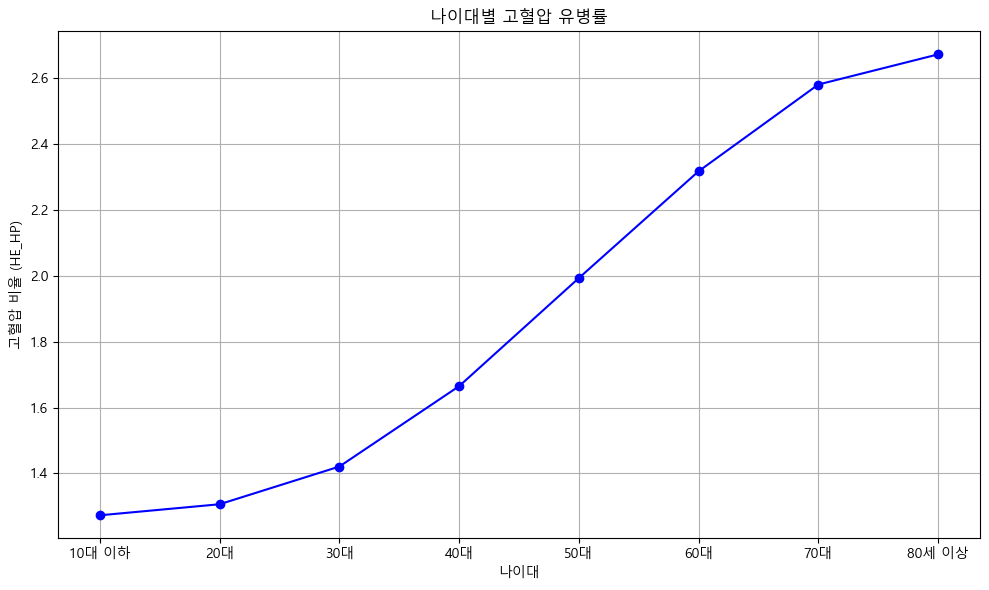

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 나이 그룹 생성 (AGE_GROUP 컬럼 추가)
bins = [0, 19, 29, 39, 49, 59, 69, 79, 120]  # 80세 이상 포함
labels = ['10대 이하', '20대', '30대', '40대', '50대', '60대', '70대', '80세 이상']

data['AGE_GROUP'] = pd.cut(data['age'], bins=bins, labels=labels, right=True)

# 2. 나이그룹별 당뇨병 평균값(= 유병률) 계산
group_stats = data.groupby('AGE_GROUP')['HE_HP'].mean().reset_index()

# 3. 시각화
plt.figure(figsize=(10, 6))
plt.plot(group_stats['AGE_GROUP'], group_stats['HE_HP'], marker='o', color='blue')
plt.xlabel('나이대')
plt.ylabel('고혈압 비율 (HE_HP)')
plt.title('나이대별 고혈압 유병률')
plt.grid(True)
plt.tight_layout()
plt.show()

**당뇨병 예측 모델 선정**


▶ Mean F1 score (CV) of D_tree: 92.35%
▶ Test F1 score of D_tree: 38.03%
▶ Test Accuracy of D_tree: 53.97%

▶ Mean F1 score (CV) of RF: 92.78%
▶ Test F1 score of RF: 38.03%
▶ Test Accuracy of RF: 53.97%


  File "C:\Users\asia\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\anaconda3\envs\py312ff2\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\anaconda3\envs\py312ff2\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\anaconda3\envs\py312ff2\Lib\subprocess.py", line 1540, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



▶ Mean F1 score (CV) of HistGB: 95.60%
▶ Test F1 score of HistGB: 38.03%
▶ Test Accuracy of HistGB: 53.97%

▶ Mean F1 score (CV) of XGB: 95.69%
▶ Test F1 score of XGB: 3.98%
▶ Test Accuracy of XGB: 15.14%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 11188, number of used features: 11
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 11189, number of used features: 11
[LightGBM] [Info] Start training from score -1.098612


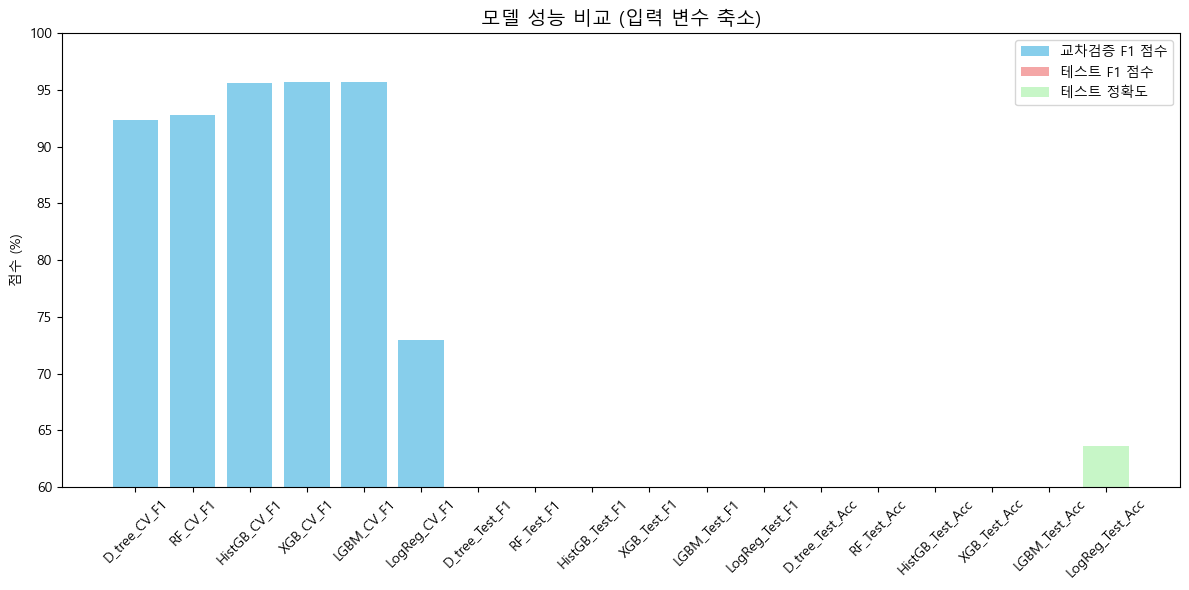

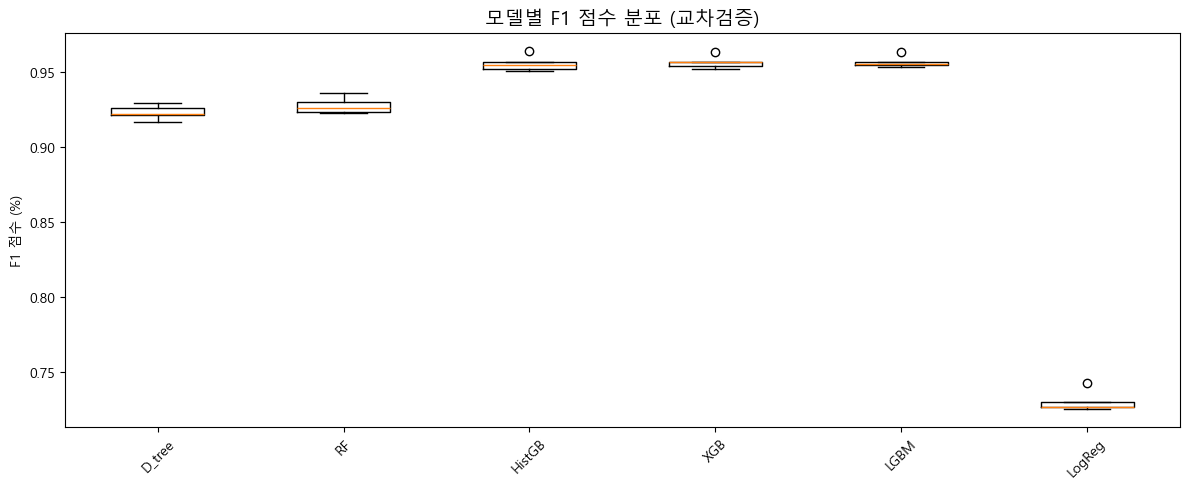

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_DM_HbA1c_input_features = ['HE_HbA1c','HE_glu', 'HE_wc',  'HE_sbp1', 'HE_BMI', 'HE_TG', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2', 'sex', 'age']
X = data[HE_DM_HbA1c_input_features]
y = data['HE_DM_HbA1c'].astype(int) - 1

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 분류기 정의
classifiers = [
    ('D_tree', DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=0, class_weight='balanced')),
    ('RF', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0, class_weight='balanced')),
    ('HistGB', HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=0)),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)),
    ('LGBM', LGBMClassifier(random_state=0, class_weight='balanced')),
    ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0))
]

classifier_names = [name for name, _ in classifiers]
classifiers = [clf for _, clf in classifiers]

# 결과 저장용 리스트
modelaccuracies = []
modelmeans = []
modelnames = []
modeltest_f1 = []
modeltest_acc = []

# 모델 훈련 및 평가
for classifier_name, classifier in zip(classifier_names, classifiers):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = cross_val_score(classifier, X_train_smote, y_train_smote, cv=skf, scoring='f1_weighted')
    print(f"\n▶ Mean F1 score (CV) of {classifier_name}: {accuracies.mean()*100:.2f}%")
    modelaccuracies.append(accuracies)
    modelnames.append(classifier_name)
    modelmeans.append(accuracies.mean()*100)

    classifier.fit(X_train_smote, y_train_smote)
    y_pred = classifier.predict(X_test_scaled)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_acc = accuracy_score(y_test, y_pred)
    modeltest_f1.append(test_f1*100)
    modeltest_acc.append(test_acc*100)
    print(f"▶ Test F1 score of {classifier_name}: {test_f1*100:.2f}%")
    print(f"▶ Test Accuracy of {classifier_name}: {test_acc*100:.2f}%")

# 성능 바 차트 (CV, Test F1, Test Accuracy)
plt.figure(figsize=(12, 6))
plt.ylim([60, 100])
plt.bar([name + "_CV_F1" for name in modelnames], modelmeans, color='skyblue', label='교차검증 F1 점수')
plt.bar([name + "_Test_F1" for name in modelnames], modeltest_f1, color='lightcoral', label='테스트 F1 점수', alpha=0.7)
plt.bar([name + "_Test_Acc" for name in modelnames], modeltest_acc, color='lightgreen', label='테스트 정확도', alpha=0.5)

plt.xticks(rotation=45)
plt.ylabel('점수 (%)')
plt.title('모델 성능 비교 (입력 변수 축소)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

# Boxplot (CV F1 분포)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.boxplot(modelaccuracies)
ax.set_xticklabels(modelnames, rotation=45)
ax.set_ylabel('F1 점수 (%)')
ax.set_title('모델별 F1 점수 분포 (교차검증)', fontsize=14)
plt.tight_layout()
plt.show()


In [76]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np


# 2. X와 y 정의
HE_DM_HbA1c_input_features = ['HE_glu', 'HE_wc', 'HE_sbp1', 'HE_BMI', 'HE_TG', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2', 'sex', 'age']

X = data[HE_DM_HbA1c_input_features]
y = data['HE_DM_HbA1c'].astype(int) - 1 


# 3. 데이터 분할 (훈련 세트, 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


# 4. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train) # 스케일링된 데이터에 SMOTE 적용


# 6. HistGradientBoostingClassifier 정의 및 학습    0.1, 100, 0 일 때 정확도 76%,  0.44      0.42      0.43
hgb_clf = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=0)

# 교차 검증 (SMOTE 적용 데이터로 CV 수행)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_f1_scores = cross_val_score(hgb_clf, X_train_smote, y_train_smote, cv=skf, scoring='f1_weighted', n_jobs=1)

print(f"▶ HistGradientBoostingClassifier의 평균 F1 점수 (5-Fold CV): {cv_f1_scores.mean()*100:.2f}%")
print(f"각 폴드의 F1 점수: {cv_f1_scores}")

# 최종 모델 학습 (전체 SMOTE 훈련 데이터 사용)
hgb_clf.fit(X_train_smote, y_train_smote)

# 7. 테스트 세트 예측 및 평가
y_pred = hgb_clf.predict(X_test_scaled)
y_proba = hgb_clf.predict_proba(X_test_scaled) # 확률 예측 (필요시 임계값 조정용)

THRESHOLD_CLASS1 = 0.32
THRESHOLD_CLASS2 = 0.5  # 기존 유지

y_pred_thresholded = []
for probs in y_proba:
    if probs[1] > THRESHOLD_CLASS1:
        y_pred_thresholded.append(1)
    elif probs[2] > THRESHOLD_CLASS2:
        y_pred_thresholded.append(2)
    else:
        y_pred_thresholded.append(0)




print("\n--- HistGradientBoostingClassifier 최종 테스트 세트 평가 결과 ---")
target_names = ['정상 (Class 0)', '당뇨병전단계 (Class 1)', '당뇨병 (Class 2)']

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

test_f1 = f1_score(y_test, y_pred, average='weighted')
test_acc = accuracy_score(y_test, y_pred)
print(f"▶ 테스트 F1 점수 (Weighted): {test_f1*100:.2f}%")
print(f"▶ 테스트 정확도: {test_acc*100:.2f}%")

# 클래스별 정밀도, 재현율, F1-score 상세 출력
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1, 2])
print("\n클래스별 정밀도, 재현율, F1-score:")
for i, (p, r, f, s) in enumerate(zip(precision, recall, fscore, support)):
    print(f"  {target_names[i]}: Precision={p:.4f}, Recall={r:.4f}, F1-score={f:.4f}, Support={s}")

# 특히 당뇨병전단계 (Class 1)의 성능 강조
pre_diabetes_precision = precision[1]
pre_diabetes_recall = recall[1]
pre_diabetes_f1 = fscore[1]
print(f"\n** 당뇨병전단계 (Class 1) 성능: **")
print(f"   Precision: {pre_diabetes_precision:.4f}")
print(f"   Recall: {pre_diabetes_recall:.4f}")
print(f"   F1-score: {pre_diabetes_f1:.4f}")

▶ HistGradientBoostingClassifier의 평균 F1 점수 (5-Fold CV): 83.54%
각 폴드의 F1 점수: [0.83471112 0.83731899 0.83912022 0.83285933 0.83301089]

--- HistGradientBoostingClassifier 최종 테스트 세트 평가 결과 ---

Classification Report:
                  precision    recall  f1-score   support

    정상 (Class 0)       0.87      0.85      0.86      7917
당뇨병전단계 (Class 1)       0.49      0.45      0.47      1759
   당뇨병 (Class 2)       0.63      0.77      0.69      1378

        accuracy                           0.78     11054
       macro avg       0.66      0.69      0.67     11054
    weighted avg       0.78      0.78      0.78     11054

▶ 테스트 F1 점수 (Weighted): 77.75%
▶ 테스트 정확도: 77.77%

클래스별 정밀도, 재현율, F1-score:
  정상 (Class 0): Precision=0.8705, Recall=0.8527, F1-score=0.8615, Support=7917
  당뇨병전단계 (Class 1): Precision=0.4895, Recall=0.4491, F1-score=0.4684, Support=1759
  당뇨병 (Class 2): Precision=0.6267, Recall=0.7663, F1-score=0.6895, Support=1378

** 당뇨병전단계 (Class 1) 성능: **
   Precision: 0.4895
   Recall: 0

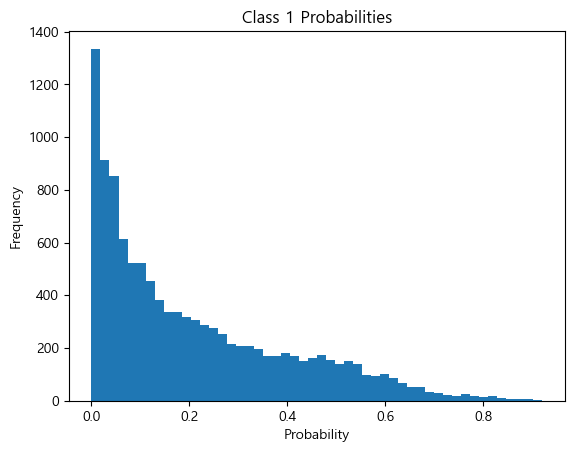

In [77]:
import matplotlib.pyplot as plt

class1_probs = y_proba[:, 1]
plt.hist(class1_probs, bins=50)
plt.title("Class 1 Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

x축 (Probability): 모델이 테스트 샘플 각각에 대해 "이 샘플은 Class 1일 확률"이라고 판단한 값

y축 (Frequency): 해당 확률대에 속한 샘플의 수  
📌 관찰된 패턴:
대부분의 샘플이 0.0 ~ 0.2 사이에 몰려 있음

0.4 이상인 샘플은 거의 없음

하지만 0.3~0.5에도 어느 정도 샘플이 있음 → 잠재적으로 Class 1일 가능성이 있는 영역

In [101]:
print(data['HE_DM_HbA1c'].value_counts(dropna=False))

HE_DM_HbA1c
1.0    41727
2.0     8801
3.0     7348
Name: count, dtype: int64


In [116]:
print(data['HE_HP'].value_counts(dropna=False))


HE_HP
1.0    25102
3.0    17861
2.0    12987
4.0     1926
Name: count, dtype: int64


모델 선정 : HistGB vs XGBoost

In [ ]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np

# 2. X와 y 정의
HE_DM_HbA1c_input_features = ['HE_glu', 'HE_wc', 'HE_sbp1', 'HE_BMI', 'HE_TG', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2', 'sex', 'age']

X = data[HE_DM_HbA1c_input_features]
y = data['HE_DM_HbA1c'].astype(int) - 1 


# 3. 데이터 분할 (훈련 세트, 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


# 4. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train) # 스케일링된 데이터에 SMOTE 적용


# 6. HistGradientBoostingClassifier 정의 및 학습    0.1, 100, 0 일 때 정확도 76%,  0.44      0.42      0.43
hgb_clf = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=0)

# 교차 검증 (SMOTE 적용 데이터로 CV 수행)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_f1_scores = cross_val_score(hgb_clf, X_train_smote, y_train_smote, cv=skf, scoring='f1_weighted', n_jobs=-1)

print(f"▶ HistGradientBoostingClassifier의 평균 F1 점수 (5-Fold CV): {cv_f1_scores.mean()*100:.2f}%")
print(f"각 폴드의 F1 점수: {cv_f1_scores}")

# 최종 모델 학습 (전체 SMOTE 훈련 데이터 사용)
hgb_clf.fit(X_train_smote, y_train_smote)

# 7. 테스트 세트 예측 및 평가
y_pred = hgb_clf.predict(X_test_scaled)
y_proba = hgb_clf.predict_proba(X_test_scaled) # 확률 예측 (필요시 임계값 조정용)

print("\n--- HistGradientBoostingClassifier 최종 테스트 세트 평가 결과 ---")
target_names = ['정상 (Class 0)', '당뇨병전단계 (Class 1)', '당뇨병 (Class 2)']

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

test_f1 = f1_score(y_test, y_pred, average='weighted')
test_acc = accuracy_score(y_test, y_pred)
print(f"▶ 테스트 F1 점수 (Weighted): {test_f1*100:.2f}%")
print(f"▶ 테스트 정확도: {test_acc*100:.2f}%")

# 클래스별 정밀도, 재현율, F1-score 상세 출력
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1, 2])
print("\n클래스별 정밀도, 재현율, F1-score:")
for i, (p, r, f, s) in enumerate(zip(precision, recall, fscore, support)):
    print(f"  {target_names[i]}: Precision={p:.4f}, Recall={r:.4f}, F1-score={f:.4f}, Support={s}")

# 특히 당뇨병전단계 (Class 1)의 성능 강조
pre_diabetes_precision = precision[1]
pre_diabetes_recall = recall[1]
pre_diabetes_f1 = fscore[1]
print(f"\n** 당뇨병전단계 (Class 1) 성능: **")
print(f"   Precision: {pre_diabetes_precision:.4f}")
print(f"   Recall: {pre_diabetes_recall:.4f}")
print(f"   F1-score: {pre_diabetes_f1:.4f}")

**고혈압 다중 모델 비교**


▶ Mean F1 score (CV) of D_tree: 64.50%
▶ Test F1 score of D_tree: 62.61%
▶ Test Accuracy of D_tree: 58.55%

▶ Mean F1 score (CV) of RF: 69.05%
▶ Test F1 score of RF: 69.26%
▶ Test Accuracy of RF: 67.80%

▶ Mean F1 score (CV) of HistGB: 73.55%
▶ Test F1 score of HistGB: 74.16%
▶ Test Accuracy of HistGB: 74.00%

▶ Mean F1 score (CV) of XGB: 73.32%
▶ Test F1 score of XGB: 73.98%
▶ Test Accuracy of XGB: 74.04%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 35369, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing wa

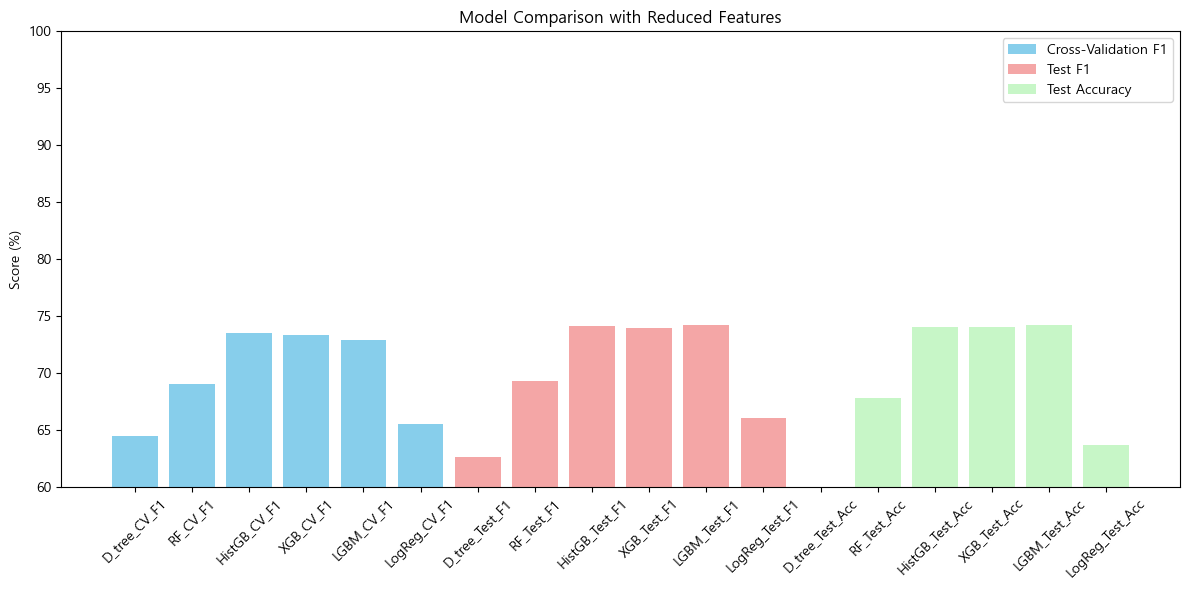

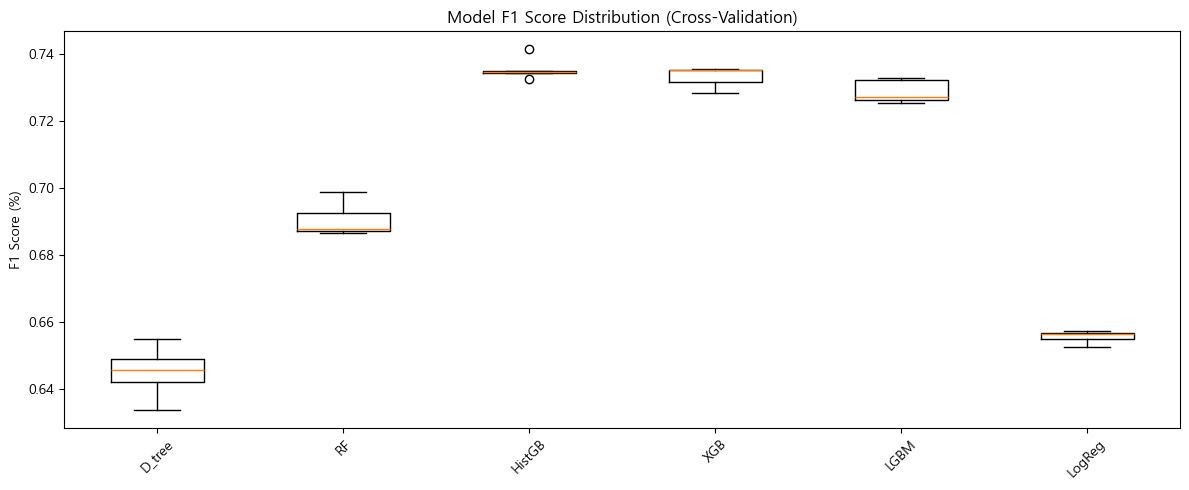

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt


# 입력 피처 및 타겟 설정
HE_HP_input_features= ['age','HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG', 'HE_crea', 'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2']

# X와 y 정의
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 분류기 정의
classifiers = [
    ('D_tree', DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=0, class_weight='balanced')),
    ('RF', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0, class_weight='balanced')),
    ('HistGB', HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=0)),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)),
    ('LGBM', LGBMClassifier(random_state=0, class_weight='balanced')),
    ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0))
]

classifier_names = [name for name, _ in classifiers]
classifiers = [clf for _, clf in classifiers]

# 결과 저장용 리스트
modelaccuracies = []
modelmeans = []
modelnames = []
modeltest_f1 = []
modeltest_acc = []

# 모델 훈련 및 평가
for classifier_name, classifier in zip(classifier_names, classifiers):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = cross_val_score(classifier, X_train, y_train, cv=skf, scoring='f1_weighted')
    print(f"\n▶ Mean F1 score (CV) of {classifier_name}: {accuracies.mean()*100:.2f}%")
    modelaccuracies.append(accuracies)
    modelnames.append(classifier_name)
    modelmeans.append(accuracies.mean()*100)

    classifier.fit(X_train_smote, y_train_smote)
    y_pred = classifier.predict(X_test)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_acc = accuracy_score(y_test, y_pred)
    modeltest_f1.append(test_f1*100)
    modeltest_acc.append(test_acc*100)
    print(f"▶ Test F1 score of {classifier_name}: {test_f1*100:.2f}%")
    print(f"▶ Test Accuracy of {classifier_name}: {test_acc*100:.2f}%")

# 성능 시각화
plt.figure(figsize=(12, 6))
plt.ylim([60, 100])
plt.bar([name + "_CV_F1" for name in modelnames], modelmeans, color='skyblue', label='Cross-Validation F1')
plt.bar([name + "_Test_F1" for name in modelnames], modeltest_f1, color='lightcoral', label='Test F1', alpha=0.7)
plt.bar([name + "_Test_Acc" for name in modelnames], modeltest_acc, color='lightgreen', label='Test Accuracy', alpha=0.5)
plt.xticks(rotation=45)
plt.ylabel('Score (%)')
plt.title('Model Comparison with Reduced Features')
plt.legend()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.boxplot(modelaccuracies)
ax.set_xticklabels(modelnames, rotation=45)
ax.set_ylabel('F1 Score (%)')
ax.set_title('Model F1 Score Distribution (Cross-Validation)')
plt.tight_layout()
plt.show()


**고혈압 모델 선정 = HistGB**

In [180]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt


# 입력 피처 및 타겟 설정
HE_HP_input_features= ['HE_sbp1', 'HE_BMI','HE_dbp1',  'HE_wc', 'HE_glu', 'HE_TG', 'HE_crea', 'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2']

# X와 y 정의
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1

# 훈련/테스트 분할 먼저 수행
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 데이터에만 fit_transform
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터에는 transform만 적용


from sklearn.metrics import classification_report

from sklearn.utils.class_weight import compute_class_weight

# 클래스 가중치 계산 ('balanced'는 빈도수에 반비례하여 자동 계산)
# compute_class_weight 함수에 원본 훈련 데이터의 y 값을 전달해야 합니다.
# 만약 SMOTE 적용 후의 데이터로 가중치를 계산하고 싶다면 y_train_smote를 전달합니다.
classes = np.unique(y_train) # 원본 훈련 데이터의 클래스 레이블
weights = compute_class_weight('balanced', classes=classes, y=y_train)

# 계산된 가중치를 딕셔너리 형태로 변환 {클래스_라벨: 가중치}
class_weights_dict = dict(zip(classes, weights))

print(f"계산된 클래스 가중치: {class_weights_dict}")


# HistGradientBoostingClassifier 모델 학습 (class_weight 적용)
# best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42) # 기존 모델
# class_weight 매개변수 추가
best_model_weighted = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=100,
    random_state=42,
    class_weight=class_weights_dict # 또는 'balanced' 문자열 사용 가능
)

# 스케일링된 훈련 데이터로 학습 (SMOTE 미적용 시 X_train_scaled 사용)
# 만약 SMOTE 결과를 사용한다면 X_train_smote_scaled (SMOTE 후 스케일링된 데이터) 사용
best_model_weighted.fit(X_train_scaled, y_train)

# 스케일링된 테스트 데이터로 예측
y_pred_weighted = best_model_weighted.predict(X_test_scaled)

# 성능 평가
print("\nClass Weight 적용 후 Classification Report:")
# y_test는 원본 테스트 데이터의 라벨입니다. 예측 결과와 비교합니다.
print(classification_report(y_test, y_pred_weighted))

# 추가적으로 F1 스코어를 각 클래스별로 확인하여 개선되었는지 비교합니다.
f1_weighted = f1_score(y_test, y_pred_weighted, average=None)
print(f"\nClass Weight 적용 후 클래스별 F1-score: {f1_weighted}")

계산된 클래스 가중치: {np.int64(0): np.float64(0.5643564356435643), np.int64(1): np.float64(3.1528384279475983), np.int64(2): np.float64(1.78125), np.int64(3): np.float64(0.7410195005131714)}

Class Weight 적용 후 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       959
           1       0.34      0.49      0.40       172
           2       0.54      0.64      0.59       304
           3       0.73      0.63      0.67       731

    accuracy                           0.71      2166
   macro avg       0.62      0.65      0.63      2166
weighted avg       0.73      0.71      0.71      2166


Class Weight 적용 후 클래스별 F1-score: [0.84004237 0.4        0.58558559 0.67452135]


**고혈압 모델 선정 = HistGB + 파생변수 추가**

In [97]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   --- ------------------------------------ 9.7/102.4 MB 54.9 MB/s eta 0:00:02
   ---- ----------------------------------- 10.5/102.4 MB 36.3 MB/s eta 0:00:03
   ---- ----------------------------------- 11.5/102.4 MB 18.5 MB/s eta 0:00:05
   --------- ------------------------------ 24.4/102.4 MB 29.7 MB/s eta 0:00:03
   --------------- ------------------------ 39.8/102.4 MB 39.6 MB/s eta 0:00:02
   ------------------- -------------------- 50.6/102.4 MB 40.8 MB/s eta 0:00:02
   ----------------------- ---------------- 59.0/102.4 MB 41.3 MB/s eta 0:00:02
   -------------------------- ------------- 67.1/102.4 MB 40.3 MB/s eta 0:00:01
   -------------------------------- ------- 82.3/102.4 MB 43.8 MB/s eta 0:00:01
   -------------------------------------- - 97.8/102.4 MB 46.6 MB/s eta 0:00:01
   --------------------------------------  102.2/102

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import shap

# 1. 데이터 준비 (예시 데이터 로드, 실제 데이터로 대체 필요)
# X, y는 실제 데이터로 대체해야 합니다.
# 예: df = pd.read_csv('your_data.csv')
HE_HP_input_features = ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_BMI', 
                        'HE_TG', 'HE_crea', 'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2','age']

# X와 y 정의
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1



# 2. 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. 피처 전처리: 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_train = pd.DataFrame(X_train_scaled, columns=HE_HP_input_features)
X_val = pd.DataFrame(X_val_scaled, columns=HE_HP_input_features)

# 클래스 가중치 수동 조정 (클래스 3 가중치를 더 높게 설정)
class_weights = [1.0, 1.0, 1.0, 10.0]  # 클래스 3에 5배 가중치 부여

# 5. CatBoost 모델 정의 및 학습
model = CatBoostClassifier(
    # iterations=1000,
    # learning_rate=0.05,
    # depth=6,
    # class_weights=class_weights,
    # eval_metric='MultiClass',
    # random_seed=42,
    # verbose=100,
    # early_stopping_rounds=50
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    class_weights=class_weights,
    eval_metric='MultiClass',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)
model.fit(X_train, y_train, eval_set=(X_val, y_val))

# 6. 성능 평가
y_pred = model.predict(X_val)
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


0:	learn: 1.3583753	test: 1.3583893	best: 1.3583893 (0)	total: 8.77ms	remaining: 8.76s
100:	learn: 0.8067331	test: 0.8191734	best: 0.8191734 (100)	total: 473ms	remaining: 4.21s
200:	learn: 0.7439286	test: 0.7738662	best: 0.7738662 (200)	total: 928ms	remaining: 3.69s
300:	learn: 0.7116814	test: 0.7564964	best: 0.7564964 (300)	total: 1.38s	remaining: 3.21s
400:	learn: 0.6841577	test: 0.7446773	best: 0.7446773 (400)	total: 1.82s	remaining: 2.72s
500:	learn: 0.6580274	test: 0.7339113	best: 0.7339113 (500)	total: 2.25s	remaining: 2.24s
600:	learn: 0.6356619	test: 0.7271453	best: 0.7271453 (600)	total: 2.68s	remaining: 1.78s
700:	learn: 0.6164486	test: 0.7236535	best: 0.7235086 (690)	total: 3.11s	remaining: 1.33s
800:	learn: 0.5987552	test: 0.7204558	best: 0.7204010 (799)	total: 3.55s	remaining: 883ms
900:	learn: 0.5830293	test: 0.7189527	best: 0.7188633 (896)	total: 3.99s	remaining: 438ms
999:	learn: 0.5678944	test: 0.7173853	best: 0.7172271 (992)	total: 4.43s	remaining: 0us

bestTest = 0.7

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier # LightGBM (LGBM)
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier # HistGradientBoostingClassifier (HistGB)
from sklearn.ensemble import VotingClassifier, StackingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline # imblearn의 파이프라인
from sklearn.pipeline import Pipeline # sklearn의 파이프라인

# 경고 메시지 무시 (선택 사항)
import warnings
warnings.filterwarnings('ignore')

# --- 0. 데이터 로드 및 파생변수 생성 (이전 코드에서 가져오기) ---
# 'data' DataFrame이 이미 로드되어 있다고 가정합니다.
# 예: data = pd.read_csv('건강조사_2012~2022_통합(가공된).csv')



# 입력 피처 및 타겟 설정
HE_HP_input_features = [
     'age',
    'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG',
    'HE_crea', 'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2'
] # 'age'가 포함되어 있는지 다시 확인

# X와 y 정의
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1

# --- 1. 데이터 분할 ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 2. 전처리 및 샘플링 파이프라인 정의 ---
# 스케일링 -> SMOTE (오버샘플링) -> RandomUnderSampler (언더샘플링)

# 목표 클래스 분포 설정 (이전과 동일하게 클래스 1의 수를 기준으로 맞춰봅니다. 이 비율은 튜닝 필요!)
# 현재 클래스 수 (예시): 0:4830, 1:2501, 2:3360, 3:363
sampling_strategy = {
    0: 3000,  # 클래스 0을 3000개로 언더샘플링 (조절 가능)
    1: 2501,  # 클래스 1은 그대로 유지
    2: 3000,  # 클래스 2를 3000개로 언더샘플링 (조절 가능)
    3: 1500   # 클래스 3을 1500개로 오버샘플링 (조절 가능)
}

preprocessor_pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rus', RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42))
])

# 전처리 및 샘플링 적용
X_train_processed, y_train_processed = preprocessor_pipeline.fit_resample(X_train, y_train)
X_test_processed = preprocessor_pipeline.named_steps['scaler'].transform(X_test) # 테스트 데이터는 스케일링만

print(f"Original train set shape: {X_train.shape}, {y_train.shape}")
print(f"Resampled train set shape: {X_train_processed.shape}, {y_train_processed.shape}")
print(f"Resampled class distribution:\n{pd.Series(y_train_processed).value_counts().sort_index()}")


# --- 3. 개별 기본 모델 정의 (HistGB 및 LGBM 포함) ---
estimators = [
    ('catboost', CatBoostClassifier(iterations=500, learning_rate=0.03, depth=6,
                                    eval_metric='MultiClass', random_seed=42, verbose=0, early_stopping_rounds=50)),
    ('histgb', HistGradientBoostingClassifier(learning_rate=0.1, max_iter=300, random_state=42)), # HistGradientBoostingClassifier 추가
    ('xgb', XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6,
                          use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=300, learning_rate=0.05, num_leaves=31,
                            random_state=42, class_weight='balanced')) # LightGBM 유지
]

# --- 4. 보팅 분류기 (VotingClassifier) ---
print("\n--- VotingClassifier 학습 및 평가 ---")
# 소프트 보팅: 각 모델의 예측 확률을 평균하여 최종 예측 (더 유연함)
# weights: 각 모델에 부여할 가중치 (성능에 따라 조절 가능)
# 현재는 4개 모델이므로 가중치도 4개로 설정. CatBoost, XGBoost, LGBM, HistGB 순서입니다.
voting_clf = VotingClassifier(estimators=estimators, voting='soft', weights=[1.2, 1.0, 1.1, 1.0], n_jobs=-1)

# 학습은 샘플링된 데이터로!
voting_clf.fit(X_train_processed, y_train_processed)
y_pred_voting = voting_clf.predict(X_test_processed)

print("VotingClassifier Classification Report:")
print(classification_report(y_test, y_pred_voting))
print("VotingClassifier F1-scores per class:", f1_score(y_test, y_pred_voting, average=None))


# --- 5. 스태킹 분류기 (StackingClassifier) ---
print("\n--- StackingClassifier 학습 및 평가 ---")
# 최종 예측을 담당할 메타 모델 (final_estimator)
# 메타 모델은 간단한 모델이 좋습니다. (예: LogisticRegression, 또는 다른 트리 모델)
stacking_clf = StackingClassifier(
    estimators=estimators, # 4개 모델 포함
    final_estimator=LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=42), # 메타 모델을 LGBM으로 설정
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), # CV를 통해 메타 모델 훈련 데이터 생성
    n_jobs=-1,
    passthrough=True # 기본 모델의 원래 특성을 메타 모델에 전달할지 여부
)

# 학습은 샘플링된 데이터로!
stacking_clf.fit(X_train_processed, y_train_processed)
y_pred_stacking = stacking_clf.predict(X_test_processed)

print("StackingClassifier Classification Report:")
print(classification_report(y_test, y_pred_stacking))
print("StackingClassifier F1-scores per class:", f1_score(y_test, y_pred_stacking, average=None))

# --- 6. SHAP을 이용한 해석 (생략 가능, 필요 시 개별 모델에 대해 수행) ---
# 앙상블 모델은 SHAP 해석이 복잡할 수 있습니다.
# 각 개별 모델에 대해 SHAP을 수행하거나, StackingClassifier의 final_estimator에 대해 수행할 수 있습니다.
# explainer = shap.TreeExplainer(stacking_clf.final_estimator) # Stacking의 최종 모델 해석 예시
# shap_values = explainer.shap_values(X_test_processed)
# shap.summary_plot(shap_values, X_test_processed, feature_names=HE_HP_input_features)

Original train set shape: (44212, 12), (44212,)
Resampled train set shape: (10001, 12), (10001,)
Resampled class distribution:
HE_HP
0    3000
1    2501
2    3000
3    1500
Name: count, dtype: int64

--- VotingClassifier 학습 및 평가 ---
VotingClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      4830
           1       0.60      0.62      0.61      2501
           2       0.70      0.72      0.71      3360
           3       0.31      0.22      0.26       363

    accuracy                           0.74     11054
   macro avg       0.62      0.60      0.61     11054
weighted avg       0.74      0.74      0.74     11054

VotingClassifier F1-scores per class: [0.86538862 0.60978966 0.70802705 0.26086957]

--- StackingClassifier 학습 및 평가 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

소수클래스 문제 해결하기 첫번 째. smote 

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE


# 피처/타겟 지정
features = ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_BMI',
            'HE_TG', 'HE_crea', 'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2', 'age']
X = data[features]
y = data['HE_HP'].astype(int)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

# 가중치 계산
weights = compute_sample_weight(class_weight='balanced', y=y_res)

# HistGradientBoostingClassifier 학습
model = HistGradientBoostingClassifier(random_state=42)
model.fit(X_res, y_res, sample_weight=weights)

# 예측 및 평가
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.87      0.86      0.86      4830
           2       0.60      0.65      0.62      2501
           3       0.73      0.69      0.71      3360
           4       0.32      0.34      0.33       363

    accuracy                           0.74     11054
   macro avg       0.63      0.63      0.63     11054
weighted avg       0.75      0.74      0.74     11054



**비만**


▶ Mean F1 score (CV) of D_tree: 63.58%
▶ Test F1 score of D_tree: 87.92%
▶ Test Accuracy of D_tree: 91.60%

▶ Mean F1 score (CV) of RF: 98.86%
▶ Test F1 score of RF: 98.89%
▶ Test Accuracy of RF: 98.89%

▶ Mean F1 score (CV) of HistGB: 99.16%
▶ Test F1 score of HistGB: 98.75%
▶ Test Accuracy of HistGB: 98.75%

▶ Mean F1 score (CV) of XGB: 99.16%
▶ Test F1 score of XGB: 98.52%
▶ Test Accuracy of XGB: 98.52%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2014
[LightGBM] [Info] Number of data points in the train set: 6931, number of used features: 13
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start trainin

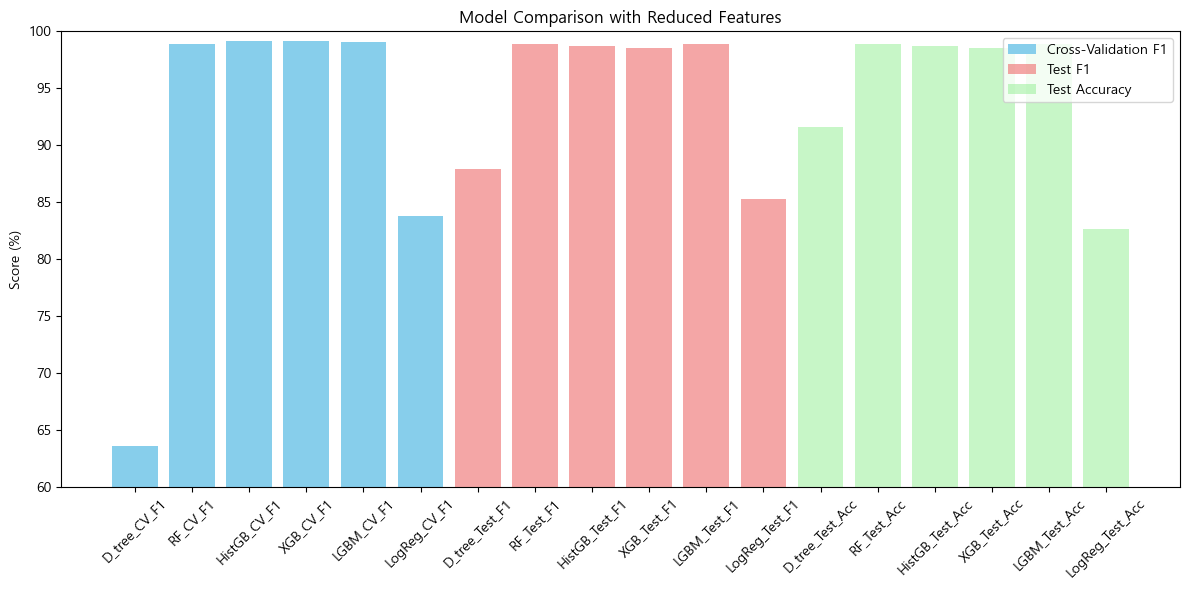

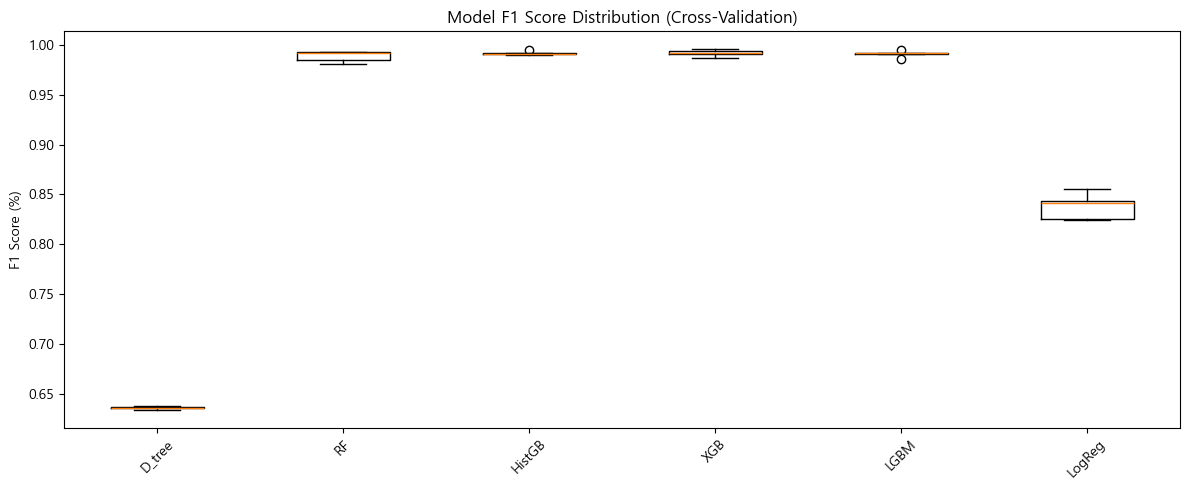

In [182]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_obe_input_features= [ 'HE_wc', 'HE_wt', 'HE_sbp1', 'HE_ht', 'HE_dbp1',  'HE_glu', 'HE_alt', 'HE_crea', 'HE_TG', 'HE_HDL_st2', "HE_BMI", 'age', 'sex']

# X와 y 정의
X = data[HE_obe_input_features]
y = data['HE_obe'].astype(int) - 1

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 분류기 정의
classifiers = [
    ('D_tree', DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=0, class_weight='balanced')),
    ('RF', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0, class_weight='balanced')),
    ('HistGB', HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=0)),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)),
    ('LGBM', LGBMClassifier(random_state=0, class_weight='balanced')),
    ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0))
]

classifier_names = [name for name, _ in classifiers]
classifiers = [clf for _, clf in classifiers]

# 결과 저장용 리스트
modelaccuracies = []
modelmeans = []
modelnames = []
modeltest_f1 = []
modeltest_acc = []

# 모델 훈련 및 평가
for classifier_name, classifier in zip(classifier_names, classifiers):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = cross_val_score(classifier, X_train, y_train, cv=skf, scoring='f1_weighted')
    print(f"\n▶ Mean F1 score (CV) of {classifier_name}: {accuracies.mean()*100:.2f}%")
    modelaccuracies.append(accuracies)
    modelnames.append(classifier_name)
    modelmeans.append(accuracies.mean()*100)

    classifier.fit(X_train_smote, y_train_smote)
    y_pred = classifier.predict(X_test)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_acc = accuracy_score(y_test, y_pred)
    modeltest_f1.append(test_f1*100)
    modeltest_acc.append(test_acc*100)
    print(f"▶ Test F1 score of {classifier_name}: {test_f1*100:.2f}%")
    print(f"▶ Test Accuracy of {classifier_name}: {test_acc*100:.2f}%")

# 성능 시각화
plt.figure(figsize=(12, 6))
plt.ylim([60, 100])
plt.bar([name + "_CV_F1" for name in modelnames], modelmeans, color='skyblue', label='Cross-Validation F1')
plt.bar([name + "_Test_F1" for name in modelnames], modeltest_f1, color='lightcoral', label='Test F1', alpha=0.7)
plt.bar([name + "_Test_Acc" for name in modelnames], modeltest_acc, color='lightgreen', label='Test Accuracy', alpha=0.5)
plt.xticks(rotation=45)
plt.ylabel('Score (%)')
plt.title('Model Comparison with Reduced Features')
plt.legend()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.boxplot(modelaccuracies)
ax.set_xticklabels(modelnames, rotation=45)
ax.set_ylabel('F1 Score (%)')
ax.set_title('Model F1 Score Distribution (Cross-Validation)')
plt.tight_layout()
plt.show()


                     precision    recall  f1-score   support

      Class 0 (Low)       0.90      0.99      0.94        90
   Class 1 (Normal)       0.98      0.97      0.97       797
Class 2 (Pre-obese)       0.93      0.94      0.94       480
   Class 2 (Obese1)       0.97      0.94      0.95       624
   Class 3 (Obese2)       0.83      0.92      0.87       115
   Class 4 (Obese3)       0.92      0.95      0.93        60

           accuracy                           0.95      2166
          macro avg       0.92      0.95      0.94      2166
       weighted avg       0.95      0.95      0.95      2166



<Figure size 600x600 with 0 Axes>

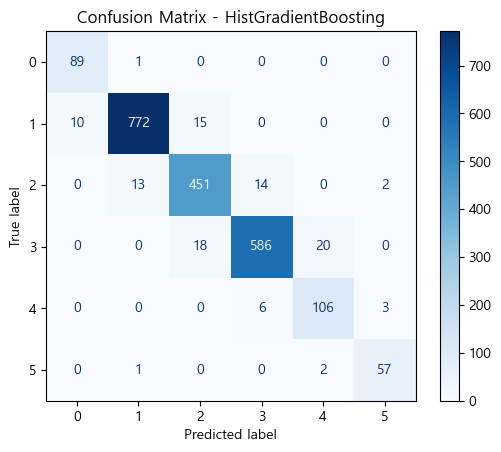

In [177]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_obe_input_features= ['HE_wc', 'HE_wt', 'HE_sbp1', 'HE_ht', 'HE_dbp1',  'HE_glu', 'HE_alt', 'HE_crea', 'HE_TG', 'HE_HDL_st2', 'age', 'sex']

# X와 y 정의
X = data[HE_obe_input_features]
y = data['HE_obe'].astype(int) - 1

# 훈련/테스트 분할 먼저 수행
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 데이터에만 fit_transform
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터에는 transform만 적용

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
# SMOTE를 스케일링된 훈련 데이터에 적용
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


from sklearn.metrics import classification_report

# HistGradientBoostingClassifier로 테스트 데이터 예측
best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
best_model.fit(X_train_smote, y_train_smote)
y_pred = best_model.predict(X_test_scaled)

# 클래스별 F1 스코어 출력
print(classification_report(y_test, y_pred, target_names=['Class 0 (Low)', 'Class 1 (Normal)', 'Class 2 (Pre-obese)', 'Class 2 (Obese1)', 'Class 3 (Obese2)', 'Class 4 (Obese3)']))
'Low', 'Normal', 'Pre-obese', 'Obese1', 'Obese2', 'Obese3'
# 평가 지표 및 혼동행렬
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(class_report).transpose()

# 시각화
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - HistGradientBoosting")
plt.show()